<a href="https://colab.research.google.com/github/Hamza-Zaman/lfb_incident_anlaysis/blob/main/lfb_hamza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q ydata-profiling ipywidgets


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install openpyxl yellowbrick

In [3]:
!pip -q install missingno scipy statsmodels


In [4]:
# ── Imports
import os, random, numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ── Theme
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.figsize": (11, 5.5),
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "axes.titleweight": "semibold",
    "figure.autolayout": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Palettes
PALET_CAT   = sns.color_palette("tab20")     # for categorical series
PALET_SEQ   = "magma"                        # for heatmaps / continuous
PALET_FLARE = "flare"                        # for ranked bars

# Reproducibility
RNG = 42
np.random.seed(RNG)
random.seed(RNG)

# Format helpers
def _fmt_int(x, pos): return f"{int(x):,}"

def barh_counts(series: pd.Series, n=10, title="Top", palette=PALET_FLARE, normalize=False):
    """Horizontal top-N counts (or shares) with labels. Read-only."""
    s = series.dropna()
    vc = s.value_counts(normalize=normalize)
    top = vc.nlargest(n)[::-1]  # ascending for nicer barh
    ax = sns.barplot(x=top.values, y=top.index, palette=sns.color_palette(palette, len(top)))
    ax.set_title(title)
    ax.set_xlabel("Share" if normalize else "Count")
    ax.set_ylabel("")
    ax.xaxis.set_major_formatter(FuncFormatter(_fmt_int if not normalize else lambda x, p: f"{x:.0%}"))
    for i, v in enumerate(top.values):
        label = f"{v:.0%}" if normalize else f"{int(v):,}"
        ax.text(v, i, f" {label}", va="center", ha="left", fontsize=10, color="#333")
    plt.tight_layout(); plt.show()

def winsorize_iqr(s: pd.Series, k=1.5):
    """Return series clipped to [Q1 - k*IQR, Q3 + k*IQR] + the bounds (read-only)."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower=lo, upper=hi), (lo, hi)

# ── Colab Drive mount
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from pathlib import Path

EXCEL_PATH = "/content/drive/MyDrive/LFB_hamza/LFB_2019-22.xlsx"
p = Path(EXCEL_PATH)
assert p.suffix.lower() in [".xls", ".xlsx"], "Expected an Excel file (.xls/.xlsx)"

try:
    xls = pd.ExcelFile(EXCEL_PATH, engine="openpyxl")
except Exception:
    xls = pd.ExcelFile(EXCEL_PATH)

frames, schemas = [], {}
for sh in xls.sheet_names:
    part = pd.read_excel(xls, sheet_name=sh)  # minimal assumptions here
    part["__sheet"] = sh
    part["__row_in_sheet"] = part.reset_index().index.astype("Int64")  # row provenance
    frames.append(part)
    schemas[sh] = set(part.columns.tolist())

# 2) Concatenate
df = pd.concat(frames, ignore_index=True, sort=False)

print(f"All rows: {len(df):,}")
print("Sheets:", xls.sheet_names)

# 3) Schema report
all_cols = sorted({c for cols in schemas.values() for c in cols})
common_cols = set.intersection(*schemas.values()) if len(schemas) > 1 else schemas[xls.sheet_names[0]]
print("\nSchema check:")
for sh in xls.sheet_names:
    missing = sorted(list(set(all_cols) - schemas[sh]))
    extra   = sorted(list(schemas[sh] - common_cols))
    print(f"  • {sh}: cols={len(schemas[sh])}, missing_vs_union={len(missing)}, extras_vs_common={len(extra)}")
    if missing:
        print("     - missing vs union:", missing[:8], "..." if len(missing) > 8 else "")
    if extra:
        print("     - extra vs common:", extra[:8], "..." if len(extra) > 8 else "")

# 4) Helper
if "DateOfCall" in df.columns:
    df["DateOfCall_dt"] = pd.to_datetime(df["DateOfCall"], errors="coerce", dayfirst=True)
else:
    df["DateOfCall_dt"] = pd.NaT

if "TimeOfCall" in df.columns:
    df["TimeOfCall_td"] = pd.to_timedelta(df["TimeOfCall"], errors="coerce")
else:
    df["TimeOfCall_td"] = pd.NaT

if "HourOfCall" in df.columns:
    df["HourOfCall_num"] = pd.to_numeric(df["HourOfCall"], errors="coerce").astype("Int64")
else:
    df["HourOfCall_num"] = pd.array([pd.NA] * len(df), dtype="Int64")

# 5) Basic checks
if "IncidentNumber" in df.columns:
    dup = df["IncidentNumber"].duplicated(keep=False).sum()
    print(f"\nDuplicate IncidentNumber rows (across sheets): {dup:,}")

if "DateOfCall_dt" in df.columns:
    print("Date range:",
          df["DateOfCall_dt"].min(), "→", df["DateOfCall_dt"].max(),
          "| missing %:", round(df["DateOfCall_dt"].isna().mean()*100, 2))

if "HourOfCall_num" in df.columns:
    h = df["HourOfCall_num"].dropna()
    print("HourOfCall range:",
          h.min(), "→", h.max(),
          "| % valid in [0..23]:", round(h.between(0,23).mean()*100, 2))

# 6) Top 3 rows
display(df.head(3)[[
    c for c in ["IncidentNumber","DateOfCall","DateOfCall_dt","TimeOfCall","TimeOfCall_td",
                "HourOfCall","HourOfCall_num","IncidentGroup","PropertyCategory",
                "PropertyType","Postcode_district","IncGeo_WardNameNew","__sheet","__row_in_sheet"]
    if c in df.columns
]])


All rows: 426,461
Sheets: ['Sheet1']

Schema check:
  • Sheet1: cols=41, missing_vs_union=0, extras_vs_common=0

Duplicate IncidentNumber rows (across sheets): 0
Date range: 2019-01-01 00:00:00 → 2022-11-30 00:00:00 | missing %: 0.0
HourOfCall range: 0 → 23 | % valid in [0..23]: 100.0


,IncidentNumber,DateOfCall,DateOfCall_dt,TimeOfCall,TimeOfCall_td,HourOfCall,HourOfCall_num,IncidentGroup,PropertyCategory,PropertyType,Postcode_district,IncGeo_WardNameNew,__sheet,__row_in_sheet
0,000006-01012019,01 Jan 2019,2019-01-01,00:01:45,0 days 00:01:45,0,0,Special Service,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,SE11,Kennington,Sheet1,0
1,000019-01012019,01 Jan 2019,2019-01-01,00:04:33,0 days 00:04:33,0,0,Fire,Outdoor,Tree scrub,N9,Lower Edmonton,Sheet1,1
2,000020-01012019,01 Jan 2019,2019-01-01,00:04:39,0 days 00:04:39,0,0,False Alarm,Outdoor,Domestic garden (vegetation not equipment),N20,Brunswick Park,Sheet1,2


In [6]:
# Ingestion QA
def qa_ingest(df, xls_names, frames, expected_cols):
    # 1) Rows per sheet (kept in a dict for quick inspection/logging)
    rows_by_sheet = {sh: len(fr) for sh, fr in zip(xls_names, frames)}

    # 2) Duplicate column names
    dup_cols = df.columns[df.columns.duplicated()].tolist()
    assert not dup_cols, f"Duplicate column names found: {dup_cols}"

    # 3) Schema check
    cols_by_sheet = {sh: set(fr.columns) for sh, fr in zip(xls_names, frames)}
    common = set.intersection(*cols_by_sheet.values())
    allc   = set.union(*cols_by_sheet.values())

    mismatch = {
        sh: {
            "missing_vs_union": sorted(list(allc - cols_by_sheet[sh])),
            "extra_vs_common":  sorted(list(cols_by_sheet[sh] - common)),
        }
        for sh in xls_names
        if (allc - cols_by_sheet[sh]) or (cols_by_sheet[sh] - common)
    }
    assert not mismatch, f"Schema mismatch across sheets: {mismatch}"

    # 4) Expected columns present
    missing_expected = [c for c in expected_cols if c not in df.columns]
    assert not missing_expected, f"Missing expected columns: {missing_expected}"

    return {
        "n_rows_total": len(df),
        "rows_by_sheet": rows_by_sheet,
        "n_cols": df.shape[1],
        "n_sheets": len(xls_names),
    }

EXPECTED = [
    "IncidentNumber","DateOfCall","TimeOfCall","HourOfCall","IncidentGroup",
    "PropertyCategory","PropertyType","Postcode_district","IncGeo_WardNameNew"
]

qa_summary = qa_ingest(df, xls.sheet_names, frames, EXPECTED)
print("Ingestion QA:", qa_summary)


Ingestion QA: {'n_rows_total': 426461, 'rows_by_sheet': {'Sheet1': 426461}, 'n_cols': 44, 'n_sheets': 1}


In [7]:
# Havering slice
import pandas as pd

if "IncGeo_BoroughName" not in df.columns:
    raise KeyError("IncGeo_BoroughName column missing.")


borough_uc = df["IncGeo_BoroughName"].astype(str).str.strip().str.upper()
print("Top boroughs (all sheets):")
print(borough_uc.value_counts().head(10), "\n")


before = len(df)
mask = borough_uc.eq("HAVERING")
hav = df.loc[mask].copy()
print(f"Rows before: {before:,}  |  HAVERING: {len(hav):,}\n")


if "__sheet" in hav.columns:
    print("Havering rows by sheet:")
    print(hav["__sheet"].value_counts(), "\n")

cols = [c for c in [
    "IncidentNumber","DateOfCall","TimeOfCall","IncidentGroup",
    "PropertyCategory","PropertyType","Postcode_district","IncGeo_WardNameNew"
] if c in hav.columns]
print("Peek:")
display(hav.loc[:, cols].head(5))


Top boroughs (all sheets):
IncGeo_BoroughName
WESTMINSTER      30649
CAMDEN           18868
SOUTHWARK        18435
TOWER HAMLETS    18092
LAMBETH          17868
CROYDON          17541
HACKNEY          16953
LEWISHAM         15177
BARNET           14888
EALING           14455
Name: count, dtype: int64 

Rows before: 426,461  |  HAVERING: 9,465

Havering rows by sheet:
__sheet
Sheet1    9465
Name: count, dtype: int64 

Peek:


,IncidentNumber,DateOfCall,TimeOfCall,IncidentGroup,PropertyCategory,PropertyType,Postcode_district,IncGeo_WardNameNew
34,000139-01012019,01 Jan 2019,00:45:13,False Alarm,Non Residential,Multi-Storey car park,RM1,St. Edward's
48,000170-01012019,01 Jan 2019,01:01:23,Fire,Outdoor Structure,Common external bin storage area,RM7,Rush Green & Crowlands
86,000270-01012019,01 Jan 2019,02:09:05,Fire,Outdoor Structure,Fence,RM12,Hacton
179,000458-01012019,01 Jan 2019,13:52:52,False Alarm,Other Residential,Retirement/Old Persons Home,RM14,Cranham
285,000653-01012019,01 Jan 2019,22:49:06,Fire,Outdoor Structure,Large refuse/rubbish container (eg skip/ paladin),RM13,South Hornchurch


In [8]:
if "hav" not in globals():
    raise NameError("`hav` (Havering slice) is not defined. Run the slice cell first.")

print(f"Shape: {hav.shape}\n")

# 1) Missing values table
dtypes = hav.dtypes.astype(str)
miss_tbl = hav.isna().sum().to_frame("n_missing")
miss_tbl["pct_missing"] = (miss_tbl["n_missing"] / len(hav) * 100).round(1)
miss_tbl["dtype"] = dtypes
miss_tbl["n_unique"] = hav.nunique(dropna=True)
miss_tbl = miss_tbl.sort_values("pct_missing", ascending=False)

print("Missing values (sorted by %):")
with pd.option_context("display.max_rows", None, "display.width", 2000):
    display(miss_tbl)

# 2) Dtype counts
print("\nDtype counts:")
print(dtypes.value_counts(), "\n")

# 3) Duplicates
dup_full = int(hav.duplicated(keep=False).sum())
print(f"Duplicate full rows: {dup_full}")

if "IncidentNumber" in hav.columns:
    dup_ids = int(hav["IncidentNumber"].duplicated(keep=False).sum())
    print(f"Duplicate IncidentNumber values: {dup_ids}")
    if dup_ids > 0:
        print("Most frequent duplicate IDs:")
        display(hav.loc[hav["IncidentNumber"].duplicated(keep=False), "IncidentNumber"]
                  .value_counts().head(10))


qc = {}


if "DateOfCall_dt" in hav.columns:
    dt = hav["DateOfCall_dt"]
else:
    dt = pd.to_datetime(hav["DateOfCall"], errors="coerce", dayfirst=True) if "DateOfCall" in hav.columns else None

if dt is not None:
    qc["date_parse_ok_%"] = round(dt.notna().mean()*100, 1)
    qc["date_min"] = dt.min()
    qc["date_max"] = dt.max()

# Hour validity
hour_col = "HourOfCall_num" if "HourOfCall_num" in hav.columns else ("HourOfCall" if "HourOfCall" in hav.columns else None)
if hour_col is not None:
    h = pd.to_numeric(hav[hour_col], errors="coerce")
    qc["hour_min"] = int(h.min()) if h.notna().any() else None
    qc["hour_max"] = int(h.max()) if h.notna().any() else None
    qc["hour_valid_[0..23]_%"] = round(h.between(0,23).mean()*100, 1) if h.notna().any() else None

# Hour vs TimeOfCall consistency
if ("TimeOfCall_td" in hav.columns) and (hour_col is not None):
    hh_from_time = hav["TimeOfCall_td"].dt.components.hours
    h_num = pd.to_numeric(hav[hour_col], errors="coerce")
    qc["hour_mismatch_rows"] = int((hh_from_time.notna() & h_num.notna() & (hh_from_time != h_num)).sum())

# Pumps vs stations
if {"NumStationsWithPumpsAttending","NumPumpsAttending"} <= set(hav.columns):
    qc["stations_gt_pumps_rows"] = int((hav["NumStationsWithPumpsAttending"] > hav["NumPumpsAttending"]).sum())

# If >=2 pumps, is second pump info present?
if {"NumPumpsAttending","SecondPumpArriving_AttendanceTime","SecondPumpArriving_DeployedFromStation"} <= set(hav.columns):
    need2 = pd.to_numeric(hav["NumPumpsAttending"], errors="coerce").fillna(0) >= 2
    sec_missing = hav["SecondPumpArriving_AttendanceTime"].isna() | hav["SecondPumpArriving_DeployedFromStation"].isna()
    qc[">=2p_rows"] = int(need2.sum())
    qc[">=2p_with_second_missing"] = int((need2 & sec_missing).sum())

print("\nQC summary:")
for k, v in qc.items():
    print(f"  - {k}: {v}")


Shape: (9465, 44)

Missing values (sorted by %):


,n_missing,pct_missing,dtype,n_unique
SecondPumpArriving_AttendanceTime,6617,69.9,float64,681
SecondPumpArriving_DeployedFromStation,6617,69.9,object,11
SpecialServiceType,6197,65.5,object,19
Postcode_full,3922,41.4,object,1703
Longitude,3922,41.4,float64,5095
Latitude,3922,41.4,float64,5094
Easting_m,3922,41.4,float64,3290
Northing_m,3922,41.4,float64,3753
FirstPumpArriving_DeployedFromStation,569,6.0,object,15
FirstPumpArriving_AttendanceTime,569,6.0,float64,873



Dtype counts:
object             22
float64            12
int64               6
Int64               2
datetime64[ns]      1
timedelta64[ns]     1
Name: count, dtype: int64 

Duplicate full rows: 0
Duplicate IncidentNumber values: 0

QC summary:
  - date_parse_ok_%: 100.0
  - date_min: 2019-01-01 00:00:00
  - date_max: 2022-11-30 00:00:00
  - hour_min: 0
  - hour_max: 23
  - hour_valid_[0..23]_%: 100.0
  - hour_mismatch_rows: 0
  - stations_gt_pumps_rows: 0
  - >=2p_rows: 3145
  - >=2p_with_second_missing: 297


No duplicates, dates/hours parse 100%, hours within 0–23, and Hour vs TimeOfCall matches. Good.

Second-pump fields ~70% overall missing (expected because many incidents have 1 pump). Among ≥2-pump incidents you have 297 / 3145 ≈ 9.4% missing second-pump details → data gap to flag, not blindly impute.

SpecialServiceType 65.5% missing overall — likely because it’s only relevant when IncidentGroup == "Special Service". We should verify conditional completeness.

Geo precision (Latitude/Longitude/Easting/Northing) ~41% missing — typical redaction for dwellings. Use Ward / Postcode_district for spatial analyses and document this.

Minor: cost / pump hours have tiny missing (<1%) but are very likely heavy-tailed; handle with robust stats/log-scale later.

**EDA**

In [9]:
src = hav.copy()

LOG = {}

if "DateOfCall_dt" in src.columns:
    dt = src["DateOfCall_dt"]
else:
    dt = pd.to_datetime(src["DateOfCall"], errors="coerce", dayfirst=True)
src["Date_dt"] = dt

if "TimeOfCall_td" in src.columns:
    td = src["TimeOfCall_td"]
else:
    td = pd.to_timedelta(src["TimeOfCall"], errors="coerce")
src["Time_td"] = td

# Hour numeric
if "HourOfCall_num" in src.columns:
    hour_num = src["HourOfCall_num"].astype("Int64")
else:
    hour_num = src["HourOfCall"]
src["Hour_num"] = pd.to_numeric(hour_num, errors="coerce").astype("Int64")


src["Year"]      = src["Date_dt"].dt.year.astype("Int64")
src["Month"]     = src["Date_dt"].dt.month.astype("Int64")
src["DoW"]       = src["Date_dt"].dt.dayofweek.astype("Int64")  # 0=Mon
src["IsWeekend"] = src["DoW"].isin([5,6]).astype("int8")


bins = [-1, 5, 11, 17, 23]
labels = ["Night","Morning","Afternoon","Evening"]
src["PartOfDay"] = pd.cut(src["Hour_num"], bins=bins, labels=labels).astype("category")

# NUMERIC COLUMNS
num_wanted = [
    "FirstPumpArriving_AttendanceTime","NumStationsWithPumpsAttending",
    "NumPumpsAttending","PumpCount","PumpHoursRoundUp","Notional Cost (£)",
    "NumCalls","Easting_m","Northing_m","Latitude","Longitude"
]
for c in [c for c in num_wanted if c in src.columns]:
    src[c] = pd.to_numeric(src[c], errors="coerce")

# Geo availability
src["GeoAvailable"] = (~src[["Latitude","Longitude"]].isna().any(axis=1)).astype("int8")

# Second pump expectations & gap
src["SecondPumpExpected"] = (src["NumPumpsAttending"].fillna(0) >= 2).astype("int8")
sec_missing = src[["SecondPumpArriving_AttendanceTime","SecondPumpArriving_DeployedFromStation"]].isna().any(axis=1)
src["SecondPumpMissing"] = (src["SecondPumpExpected"].eq(1) & sec_missing).astype("int8")
LOG["second_pump_gap_rows"] = int(src["SecondPumpMissing"].sum())

def _norm_cat(s: pd.Series) -> pd.Series:

    s2 = s.astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
    return s2

for c in ["IncGeo_WardNameNew","Postcode_district","IncidentStationGround"]:
    if c in src.columns:
        src[c + "_norm"] = _norm_cat(src[c]).astype("category")


if "IncGeo_WardNameNew" in src.columns:
    raw = src["IncGeo_WardNameNew"].astype(str)
    canon = (raw.str.upper()
                  .map(raw.groupby(raw.str.upper()).agg(lambda x: x.value_counts().idxmax()))
            )
    src["Ward_canon"] = canon.astype("category")

# PropertyType grouping
if "PropertyType" in src.columns:
    pt = _norm_cat(src["PropertyType"])
    counts = pt.value_counts()
    RARE_THRESH = 20  # <- same threshold you used
    rare = counts[counts < RARE_THRESH].index
    pt_grp = pt.copy()
    pt_grp = pt_grp.astype("category")
    pt_grp = pt_grp.cat.add_categories(["Other"])
    pt_grp = pt_grp.where(~pt_grp.isin(rare), "Other")
    src["PropertyType_grp"] = pt_grp
    LOG["propertytype_unique"] = int(pt.nunique())
    LOG["propertytype_grouped_unique"] = int(pt_grp.nunique())


if "Notional Cost (£)" in src.columns:
    src["Cost_log1p"] = np.log1p(src["Notional Cost (£)"])
    # winsorized (IQR 1.5) for plots only
    s = src["Notional Cost (£)"]
    q1, q3 = s.quantile([.25,.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    src["Cost_winz"] = s.clip(lower=lo, upper=hi)

if "FirstPumpArriving_AttendanceTime" in src.columns:
    s = src["FirstPumpArriving_AttendanceTime"]
    q1, q3 = s.quantile([.25,.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    src["FirstPump_winz"] = s.clip(lower=lo, upper=hi)

hav_clean = src

# Summary
print("Prep summary:")
print(f"  - Rows: {len(hav_clean):,}")
print(f"  - GeoAvailable=1 rows: {int(hav_clean['GeoAvailable'].sum()):,}")
print(f"  - SecondPumpExpected rows: {int(hav_clean['SecondPumpExpected'].sum()):,}  "
      f"| Missing second-pump info: {LOG.get('second_pump_gap_rows', 0)}")
if "propertytype_unique" in LOG:
    print(f"  - PropertyType unique: {LOG['propertytype_unique']}  -> grouped: {LOG['propertytype_grouped_unique']} (threshold < {RARE_THRESH})")
print("  - No raw columns dropped or overwritten. All changes are helper columns.")


Prep summary:
  - Rows: 9,465
  - GeoAvailable=1 rows: 5,543
  - SecondPumpExpected rows: 3,145  | Missing second-pump info: 297
  - PropertyType unique: 210  -> grouped: 68 (threshold < 20)
  - No raw columns dropped or overwritten. All changes are helper columns.


Numeric summary:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew,excess_kurtosis,missing_%,iqr_outliers,abs_skew
FirstPumpArriving_AttendanceTime,8896.0,354.109825,154.745939,1.0,15.0,157.0,262.0,329.0,420.0,643.0,909.05,1196.0,1.277,3.617,6.01,523,1.277
NumStationsWithPumpsAttending,9192.0,1.361945,0.605779,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,6.0,2.055,6.264,2.88,107,2.055
NumPumpsAttending,9192.0,1.409487,0.665998,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,7.0,2.280,8.222,2.88,137,2.280
PumpCount,9403.0,1.571839,3.338013,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,250.0,51.560,3490.067,0.66,260,51.560
PumpHoursRoundUp,9399.0,1.878179,15.569065,1.0,1.0,1.0,1.0,1.0,1.0,3.0,10.0,1203.0,59.480,4178.312,0.70,1583,59.480
Notional Cost (£),9399.0,657.01681,5395.965594,333.0,333.0,339.0,346.0,352.0,364.0,1056.0,3390.0,407817.0,57.872,3944.638,0.70,1583,57.872
NumCalls,9465.0,1.467829,2.120883,1.0,1.0,1.0,1.0,1.0,1.0,3.0,9.0,103.0,18.930,668.018,0.00,1895,18.930
Hour_num,9465.0,13.718225,6.162541,0.0,0.0,1.0,10.0,15.0,19.0,22.0,23.0,23.0,-0.514,-0.585,0.00,0,0.514


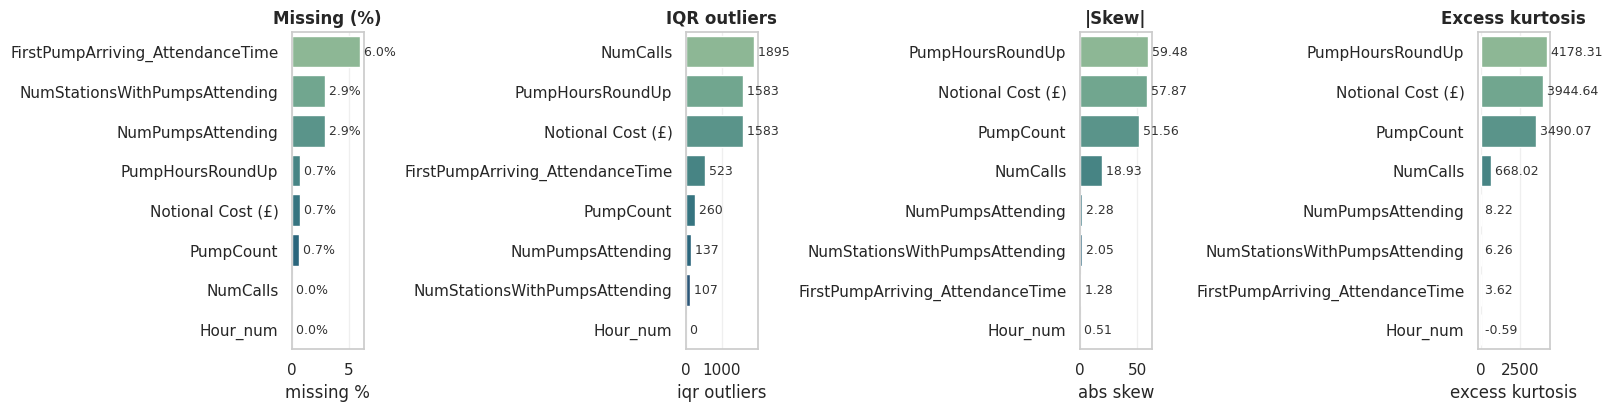

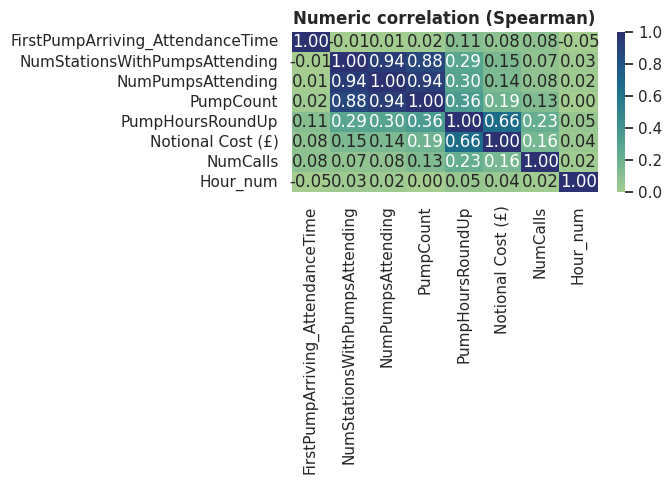

VIF calculation skipped due to: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


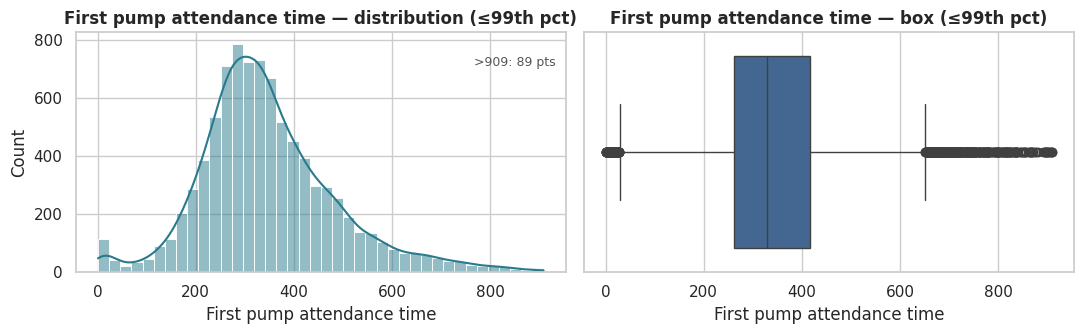

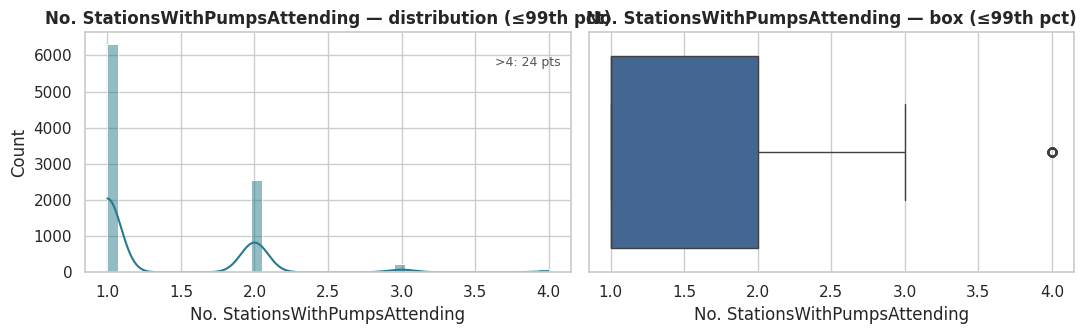

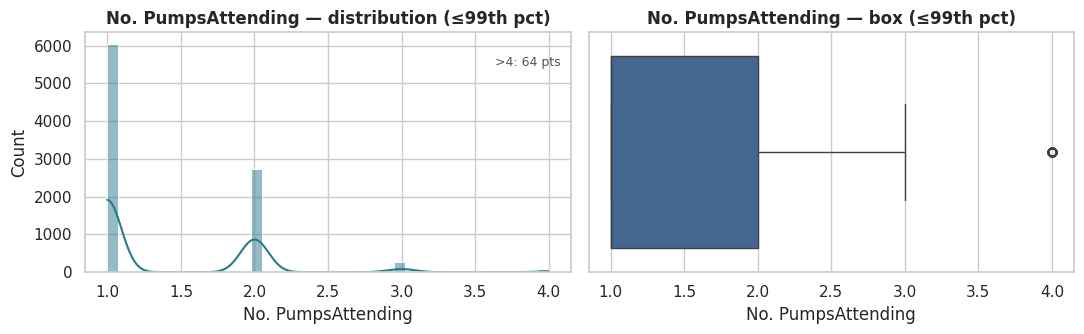

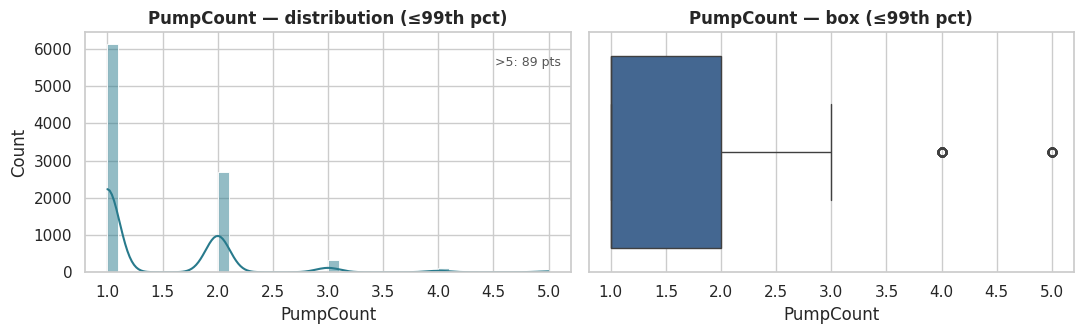

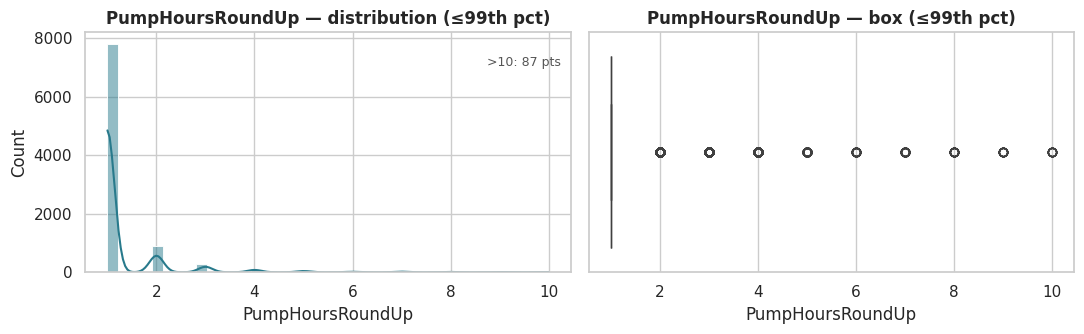

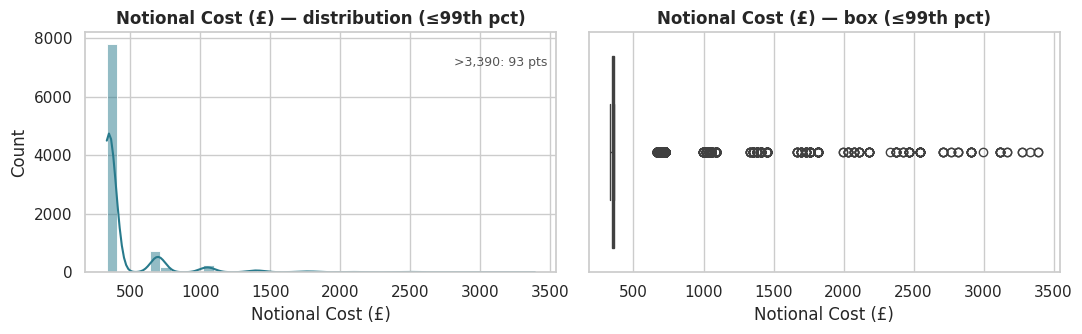

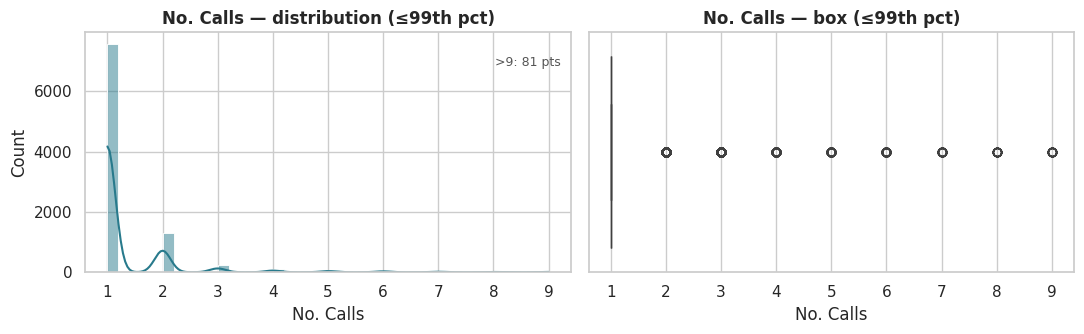

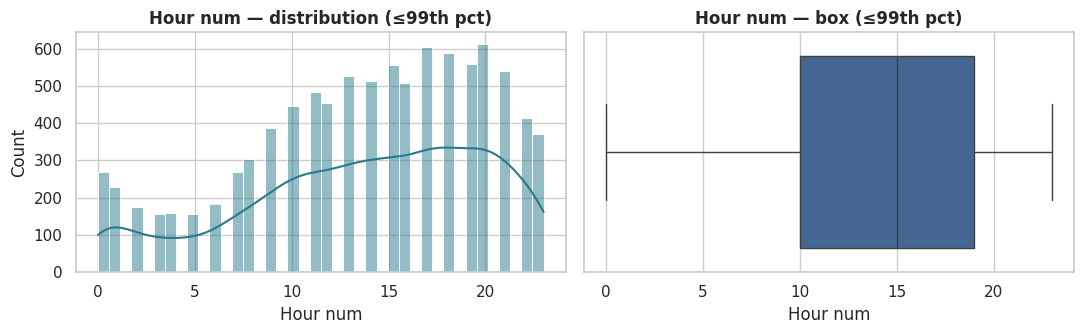

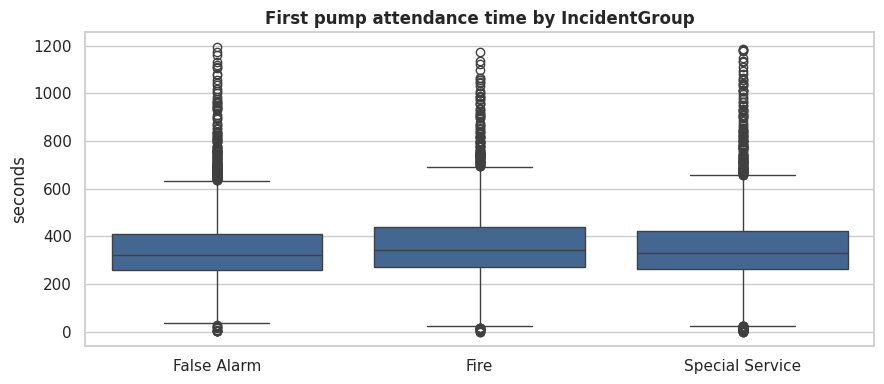

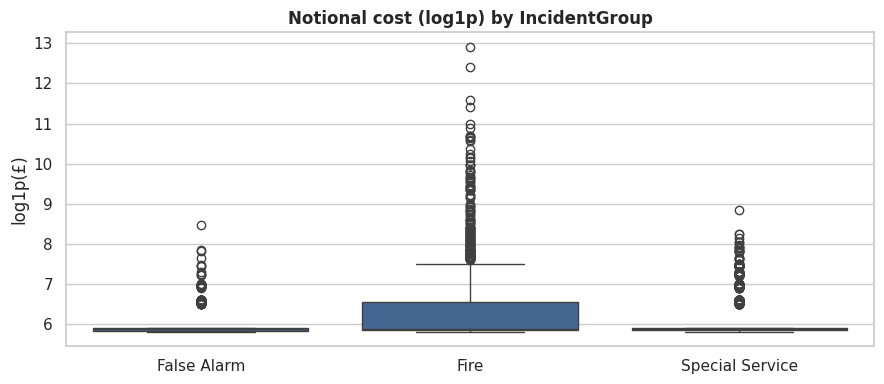

In [10]:
# =========================
# EDA quality
# =========================

from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

sns.set_context("notebook"); sns.set_style("whitegrid")

base = hav_clean.copy()
NUMS = [
    "FirstPumpArriving_AttendanceTime",
    "NumStationsWithPumpsAttending",
    "NumPumpsAttending",
    "PumpCount",
    "PumpHoursRoundUp",
    "Notional Cost (£)",
    "NumCalls",
    "Hour_num",
]
nums = [c for c in NUMS if c in base.columns]
df_num = base[nums].apply(pd.to_numeric, errors="coerce")


def iqr_outliers(s: pd.Series, k=1.5) -> int:
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty: return 0
    q1, q3 = s.quantile([.25, .75]); iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return int(((s < lo) | (s > hi)).sum())

def pretty(col: str) -> str:
    return (col.replace("_", " ")
               .replace("FirstPumpArriving", "First pump")
               .replace("AttendanceTime", "attendance time")
               .replace("Num", "No. ")
               .replace(" (£)", " (£)"))

def barh_metric(data, x, title, fmt="{x}", ax=None, cmap="crest"):
    data = data.sort_values(x, ascending=False).reset_index().rename(columns={"index": "var"})
    colors = sns.color_palette(cmap, len(data))
    if ax is None: ax = plt.gca()
    sns.barplot(
        data=data, y="var", x=x, hue="var",
        palette=colors, dodge=False, legend=False, ax=ax,
    )
    ax.set_title(title); ax.set_ylabel(""); ax.set_xlabel(x.replace("_", " "))
    for i, (v, xv) in enumerate(zip(data["var"], data[x])):
        ax.text(xv, i, f" {fmt.format(x=xv)}", va="center", ha="left", fontsize=9, color="#333")

# Numeric summary
desc = df_num.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T

sk = df_num.apply(lambda s: skew(s.dropna(), bias=False)).rename("skew")
ku_ex = df_num.apply(lambda s: kurtosis(s.dropna(), bias=False, fisher=True)).rename("excess_kurtosis")
miss_pct = (df_num.isna().mean()*100).round(2).rename("missing_%")
out_cnt = pd.Series({c: iqr_outliers(df_num[c]) for c in nums}, name="iqr_outliers")

summary = (desc.join([sk, ku_ex, miss_pct, out_cnt])
               .assign(abs_skew=lambda d: d["skew"].abs()))
print("Numeric summary:")
display(summary.round(3).loc[nums])

fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
barh_metric(summary[["missing_%"]], "missing_%", "Missing (%)", fmt="{x:.1f}%", ax=axes[0])
barh_metric(summary[["iqr_outliers"]], "iqr_outliers", "IQR outliers", fmt="{x:.0f}", ax=axes[1])
barh_metric(summary[["abs_skew"]], "abs_skew", "|Skew|", fmt="{x:.2f}", ax=axes[2])
barh_metric(summary[["excess_kurtosis"]], "excess_kurtosis", "Excess kurtosis", fmt="{x:.2f}", ax=axes[3])
for ax in axes: ax.grid(axis="x", alpha=.3)
plt.show()

# Correlation (Spearman)
if df_num.shape[1] >= 2:
    plt.figure(figsize=(7,5))
    sns.heatmap(df_num.corr(method="spearman"), annot=True, fmt=".2f", vmin=0, vmax=1, cmap="crest")
    plt.title("Numeric correlation (Spearman)"); plt.tight_layout(); plt.show()

# Multicollinearity check (VIF)
X = df_num.replace([np.inf, -np.inf], np.nan).dropna()
if X.shape[0] > 0 and X.shape[1] > 1:
    try:
        Xc = sm.add_constant(X, has_constant="add")
        vif_vals = [VIF(Xc.values, i) for i in range(1, Xc.shape[1])]
        vif = pd.Series(vif_vals, index=X.columns, name="VIF").sort_values(ascending=False)
        print("VIF (>=10 often indicates redundancy):")
        display(vif)
    except Exception as e:
        print("VIF calculation skipped due to:", e)

# Distribution + box for each numeric (cap at 99th pct)
COLOR_HIST = sns.color_palette("crest", 6)[3]
COLOR_BOX  = sns.color_palette("mako", 6)[2]

def dist_and_box(df, col, cap_pct=0.99):
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"[skip] {col} has no numeric data");
        return
    cap = s.quantile(cap_pct)
    kept = s[s <= cap]
    n_out = int((s > cap).sum())

    fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

    # left: histogram/KDE on capped range
    sns.histplot(kept, bins=40, kde=True, color=COLOR_HIST, ax=axes[0])
    axes[0].set_title(f"{pretty(col)} — distribution (≤{int(cap_pct*100)}th pct)")
    axes[0].set_xlabel(pretty(col))
    if n_out:
        axes[0].text(0.98, 0.90, f">{cap:,.0f}: {n_out} pts",
                     transform=axes[0].transAxes, ha="right", va="top",
                     fontsize=9, color="#555")

    # right: box plot on capped range
    sns.boxplot(x=kept, color=COLOR_BOX, ax=axes[1])
    axes[1].set_title(f"{pretty(col)} — box (≤{int(cap_pct*100)}th pct)")
    axes[1].set_xlabel(pretty(col))
    plt.tight_layout(); plt.show()

for c in nums:
    dist_and_box(base, c, cap_pct=0.99)

# ---- 5) By-incident-group boxplots (response time + cost on log scale)
order = ["False Alarm","Fire","Special Service"]
if {"IncidentGroup","FirstPumpArriving_AttendanceTime"} <= set(base.columns):
    plt.figure(figsize=(9,4))
    sns.boxplot(
        data=base, x="IncidentGroup", y="FirstPumpArriving_AttendanceTime",
        order=order, color=COLOR_BOX
    )
    plt.title("First pump attendance time by IncidentGroup")
    plt.xlabel(""); plt.ylabel("seconds"); plt.tight_layout(); plt.show()

if {"IncidentGroup","Notional Cost (£)"} <= set(base.columns):
    tmp = base.assign(CostLog=np.log1p(base["Notional Cost (£)"]))
    plt.figure(figsize=(9,4))
    sns.boxplot(data=tmp, x="IncidentGroup", y="CostLog", order=order, color=COLOR_BOX)
    plt.title("Notional cost (log1p) by IncidentGroup")
    plt.xlabel(""); plt.ylabel("log1p(£)"); plt.tight_layout(); plt.show()


What the charts are saying (quick, actionable)
Distributions (hist/box ≤99th pct):

FirstPumpArriving_AttendanceTime is right-skewed with a long tail and ~6% NA.

Count variables (NumPumpsAttending, NumStationsWithPumpsAttending, PumpCount, NumCalls) are heavily zero/one-inflated with rare high values.

PumpHoursRoundUp and Notional Cost (£) are extremely skewed (huge kurtosis) and strongly correlate with PumpCount.

Correlation (Spearman): very high block among PumpCount ↔ PumpHoursRoundUp ↔ Notional Cost (£) (redundancy risk).

By IncidentGroup (boxplots): fires & special services have longer first-pump times than false alarms; cost is much higher for Fire (even on log scale).

Missing-value plan (no leakage, no unjustified drops)
Keep geospatial NAs as true unknowns. Lat/long/postcode_full are systematically missing for Dwellings (policy, not data error). Don’t impute; use coarse location (Ward, District, StationGround) which are complete. Keep a binary flag GeoAvailable.

Second-pump fields are NA for single-pump jobs by design.

Create SecondPumpExpected = max(NumPumpsAttending, NumStationsWithPumpsAttending) ≥ 2.

Force second-pump columns to NA when SecondPumpExpected == 0.

For the small set where a second pump is expected but NA (~9% of those rows): fill per-station median second-pump time, fallback to overall median, and add SecondPumpMissing_when_expected flag. If you later analyze second-pump timings specifically, you can drop those 297 rows instead.

Operational numerics

FirstPumpArriving_AttendanceTime (6% NA): median impute within (StationGround × IncidentGroup × PartOfDay); fallback to global median. Add _was_missing indicator.

NumPumpsAttending, NumStationsWithPumpsAttending (2.9% each): impute group median by IncidentGroup and cast back to integer; add missing flags.

PumpCount, PumpHoursRoundUp (0.7%): impute within NumPumpsAttending; flags too.

Notional Cost (£) (0.7%): if you’ll predict incident class at call time, treat cost as post-outcome ⇒ exclude it from predictive models to avoid leakage. If you keep it for EDA/costing, impute median within (IncidentGroup × PropertyCategory); add flag.

Transformations (for later modeling, not imputation):

Use np.log1p for Notional Cost (£) and optionally PumpHoursRoundUp to tame tails.

For extremely rare highs (NumCalls, PumpCount) consider clipping at 99th pct or binning; don’t drop rows.

In [11]:
# === Missing-value handling
import numpy as np
import pandas as pd

dfi = hav_clean.copy()


geo_cols = [c for c in ["Latitude","Longitude","Postcode_full"] if c in dfi]
if geo_cols:
    dfi["GeoAvailable"] = (~dfi[geo_cols].isna().any(axis=1)).astype("Int8")

# 1) Second pump logic
dfi["SecondPumpExpected"] = (
    dfi[["NumPumpsAttending","NumStationsWithPumpsAttending"]].max(axis=1) >= 2
).astype("Int8")

for c in ["SecondPumpArriving_AttendanceTime","SecondPumpArriving_DeployedFromStation"]:
    if c in dfi.columns:

        dfi.loc[dfi["SecondPumpExpected"] == 0, c] = pd.NA

# Impute second pump only where expected
if "SecondPumpArriving_AttendanceTime" in dfi.columns:
    mask_sp_na = (dfi["SecondPumpExpected"].eq(1) &
                  dfi["SecondPumpArriving_AttendanceTime"].isna())
    dfi["SecondPumpMissing_when_expected"] = mask_sp_na.astype("Int8")

    # per-station median
    sp_station_med = (dfi.groupby("IncidentStationGround")["SecondPumpArriving_AttendanceTime"]
                        .transform("median"))
    dfi.loc[mask_sp_na, "SecondPumpArriving_AttendanceTime"] = sp_station_med[mask_sp_na]
    if dfi["SecondPumpArriving_AttendanceTime"].isna().any():
        dfi["SecondPumpArriving_AttendanceTime"] = dfi["SecondPumpArriving_AttendanceTime"]\
            .fillna(dfi["SecondPumpArriving_AttendanceTime"].median())

# 2) Missing flags for operational numerics
to_flag = ["FirstPumpArriving_AttendanceTime","NumPumpsAttending",
           "NumStationsWithPumpsAttending","PumpCount",
           "PumpHoursRoundUp","Notional Cost (£)"]
for c in [c for c in to_flag if c in dfi]:
    dfi[f"{c}_was_missing"] = dfi[c].isna().astype("Int8")

# 3) Impute with group medians (logical groups), with sensible fallbacks

# 3a) First pump time — Station × IncidentGroup × PartOfDay
grp_keys = [k for k in ["IncidentStationGround","IncidentGroup","PartOfDay"] if k in dfi]
if "FirstPumpArriving_AttendanceTime" in dfi:
    med_fp = dfi.groupby(grp_keys)["FirstPumpArriving_AttendanceTime"].transform("median")
    dfi["FirstPumpArriving_AttendanceTime"] = dfi["FirstPumpArriving_AttendanceTime"]\
        .fillna(med_fp).fillna(dfi["FirstPumpArriving_AttendanceTime"].median())

# 3b) Counts — by IncidentGroup
for c in ["NumPumpsAttending","NumStationsWithPumpsAttending"]:
    if c in dfi:
        med = dfi.groupby("IncidentGroup")[c].transform("median")
        dfi[c] = dfi[c].fillna(med).fillna(dfi[c].median()).round().astype("Int64")

# 3c) PumpCount & PumpHours — by NumPumpsAttending
if "PumpCount" in dfi:
    med = dfi.groupby("NumPumpsAttending")["PumpCount"].transform("median")
    dfi["PumpCount"] = dfi["PumpCount"].fillna(med).fillna(dfi["PumpCount"].median())
if "PumpHoursRoundUp" in dfi:
    med = dfi.groupby("NumPumpsAttending")["PumpHoursRoundUp"].transform("median")
    dfi["PumpHoursRoundUp"] = dfi["PumpHoursRoundUp"].fillna(med)\
                                           .fillna(dfi["PumpHoursRoundUp"].median())

# 3d) Cost — if you keep it for EDA/costing (avoid for early predictions)
if "Notional Cost (£)" in dfi:
    keys = [k for k in ["IncidentGroup","PropertyCategory"] if k in dfi]
    med = dfi.groupby(keys)["Notional Cost (£)"].transform("median") if keys else None
    dfi["Notional Cost (£)"] = dfi["Notional Cost (£)"].fillna(med)\
                               if med is not None else dfi["Notional Cost (£)"]
    dfi["Notional Cost (£)"] = dfi["Notional Cost (£)"].fillna(dfi["Notional Cost (£)"].median())

# 4) (Optional) Ready-to-use transformed columns for later modeling/plots
if "Notional Cost (£)" in dfi:
    dfi["Cost_log1p"] = np.log1p(dfi["Notional Cost (£)"])
for c in ["NumCalls","PumpCount","PumpHoursRoundUp"]:
    if c in dfi:
        dfi[f"{c}_p99cap"] = dfi[c].clip(upper=dfi[c].quantile(0.99))

# Final NA check on key fields
check_cols = ["FirstPumpArriving_AttendanceTime","NumPumpsAttending",
              "NumStationsWithPumpsAttending","PumpCount",
              "PumpHoursRoundUp","Notional Cost (£)"]
print("Remaining NA % on key fields:")
print(dfi[ [c for c in check_cols if c in dfi] ].isna().mean().mul(100).round(2))

# dfi is cleaned/imputed frame
hav_ready = dfi


Remaining NA % on key fields:
FirstPumpArriving_AttendanceTime    0.0
NumPumpsAttending                   0.0
NumStationsWithPumpsAttending       0.0
PumpCount                           0.0
PumpHoursRoundUp                    0.0
Notional Cost (£)                   0.0
dtype: float64


/tmp/ipython-input-3170266023.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_fp = dfi.groupby(grp_keys)["FirstPumpArriving_AttendanceTime"].transform("median")


Imputation outcome (0% NA on the operational fields) is consistent with the plan and logically defensible:

You didn’t fabricate geo data (we only flagged it).

Second-pump fields were kept NA when not expected, and only imputed when a 2nd pump was expected.

Operational numerics were filled with group medians (Station × IncidentGroup × PartOfDay for first-pump time; IncidentGroup or NumPumpsAttending for the others) and every fill got a _was_missing flag.

Cost was imputed for EDA but we’ll exclude it from prediction features to avoid leakage.

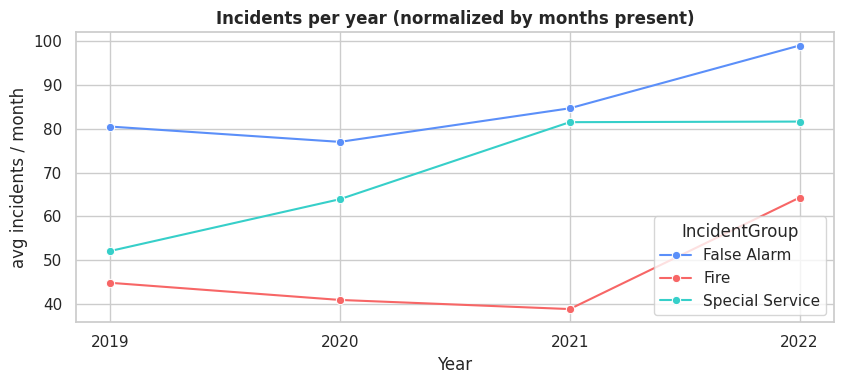

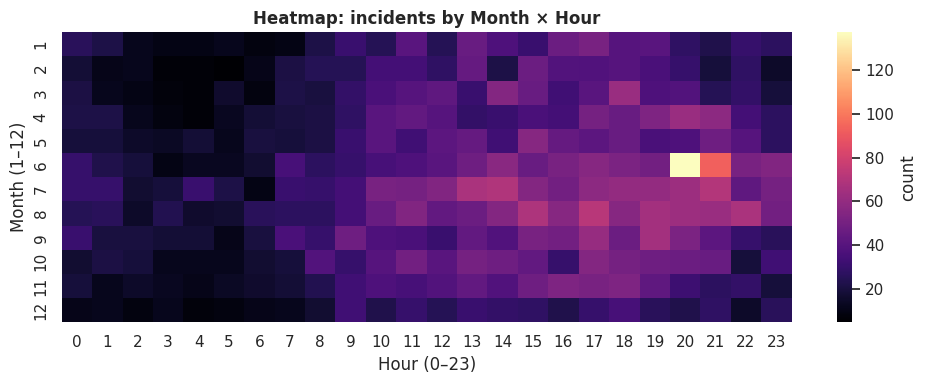

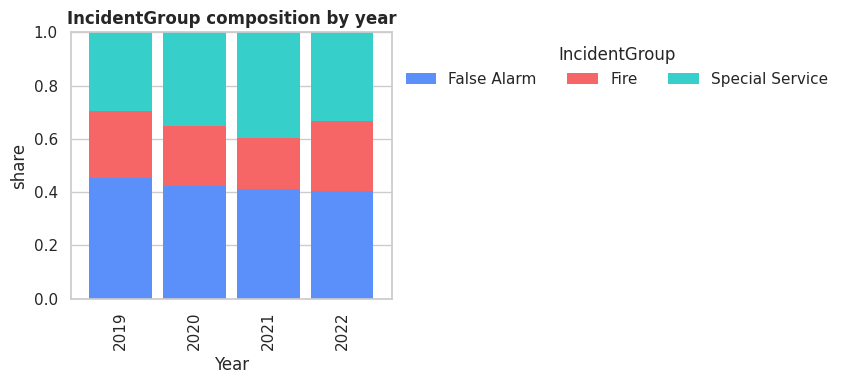

In [12]:
from matplotlib.ticker import MaxNLocator


sns.set_context("notebook"); sns.set_style("whitegrid")


dfv = dfi.copy()
dfv["Date"]  = pd.to_datetime(dfv["DateOfCall_dt"], errors="coerce")
dfv["Year"]  = dfv["Date"].dt.year.astype("Int64")
dfv["Month"] = dfv["Date"].dt.month.astype("Int64")


IG_ORDER  = ["False Alarm", "Fire", "Special Service"]
IG_COLORS = {"False Alarm": "#5B8FF9", "Fire": "#F76666", "Special Service": "#36CFC9"}

# === 1A) Year trend (normalized by months present)
yr = (dfv.groupby(["Year","IncidentGroup"], observed=True)
        .size().rename("count").reset_index())

coverage = (dfv.dropna(subset=["Year","Month"])
              .groupby("Year", observed=True)["Month"].nunique()
              .rename("months_present").reset_index())

yrn = yr.merge(coverage, on="Year", how="left")
yrn["per_month"] = yrn["count"] / yrn["months_present"].clip(lower=1)
yrn["IncidentGroup"] = pd.Categorical(yrn["IncidentGroup"], IG_ORDER, ordered=True)

plt.figure(figsize=(8.6,4))
ax = sns.lineplot(data=yrn, x="Year", y="per_month",
                  hue="IncidentGroup", hue_order=IG_ORDER,
                  palette=IG_COLORS, marker="o")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("avg incidents / month"); plt.xlabel("Year")
plt.title("Incidents per year (normalized by months present)")
plt.tight_layout(); plt.show()

# === 1B) Month × Hour heatmap (operational load)
hour_col = "Hour_num" if "Hour_num" in dfv.columns else "HourOfCall"
mxh = (dfv.groupby(["Month", hour_col], observed=True)
         .size().rename("count").reset_index())
pivot = mxh.pivot(index="Month", columns=hour_col, values="count").fillna(0)

plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap="magma", cbar_kws={"label":"count"})
plt.title("Heatmap: incidents by Month × Hour")
plt.xlabel("Hour (0–23)"); plt.ylabel("Month (1–12)")
plt.tight_layout(); plt.show()

# === 1C) Incident mix by year (stacked 100%)
mix = (dfv.groupby(["Year","IncidentGroup"], observed=True)
         .size().rename("n").reset_index())
mix["share"] = mix["n"] / mix.groupby("Year", observed=True)["n"].transform("sum")
mix["IncidentGroup"] = pd.Categorical(mix["IncidentGroup"], IG_ORDER, ordered=True)

wide = (mix.pivot(index="Year", columns="IncidentGroup", values="share")
            .reindex(columns=IG_ORDER).fillna(0))

ax = wide.plot(kind="bar", stacked=True, figsize=(8.6,4), width=0.85,
               color=[IG_COLORS[c] for c in IG_ORDER], edgecolor="none")
ax.set_ylabel("share"); ax.set_xlabel("Year"); ax.set_ylim(0,1)
ax.set_title("IncidentGroup composition by year")
ax.legend(title="IncidentGroup", ncol=3, frameon=False, bbox_to_anchor=(1,1))
plt.tight_layout(); plt.show()


Per-year (normalized): False Alarms trend up into 2022; Fire dips in 2021 then jumps in 2022; Special Service rises to 2021 then flattens.

Month × Hour heatmap: clear daily rhythm (quiet 01:00–06:00, ramp after 09:00, peak 17:00–21:00). There’s a hot spot around Month=6 (June), Hour=21 that’s unusually bright—worth a quick drill-down to confirm it isn’t driven by a single night or duplicated records.

Mix by year: composition is fairly stable (False Alarm ≈ 40–45%, Fire ≈ 20–27%, Special Service ≈ 30–38%) with only modest shifts.

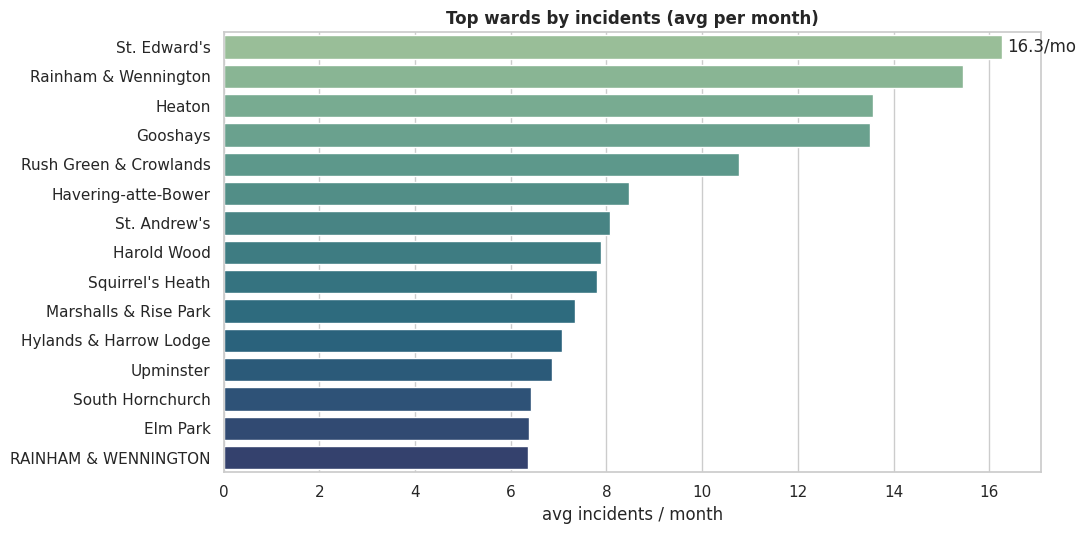

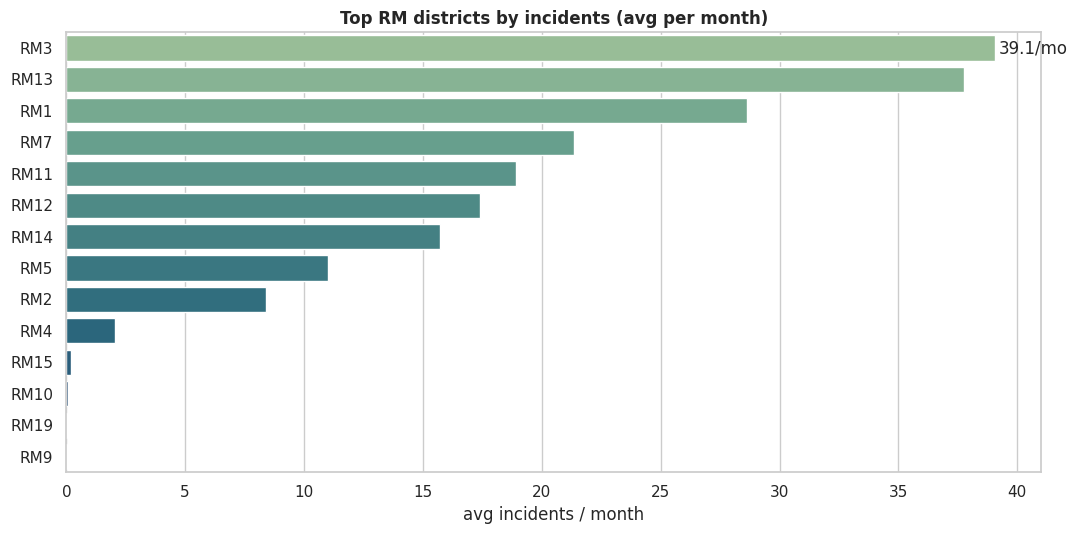

In [13]:

dfw = dfi.copy()
dfw["Year"]  = dfw["DateOfCall_dt"].dt.year.astype("Int64")
dfw["Month"] = dfw["DateOfCall_dt"].dt.month.astype("Int64")


def per_month_rate(df: pd.DataFrame, key_col: str, top_k: int = 15) -> pd.DataFrame:
    """
    Average incidents per calendar month across the period covered by `df`.
    Handles partial years by counting distinct year-months present.
    """
    # total incidents by key
    cnt = (df.groupby(key_col, observed=True)["IncidentNumber"]
             .count().rename("n").reset_index())

    # distinct (year, month) periods in this slice
    months_present = (df.loc[df["DateOfCall_dt"].notna(), "DateOfCall_dt"]
                        .dt.to_period("M").nunique())

    out = (cnt.assign(per_month = cnt["n"] / max(1, months_present))
              .sort_values("per_month", ascending=False, kind="mergesort")
              .reset_index(drop=True))
    return out.head(top_k)

def barh_ranked(data: pd.DataFrame, y: str, x: str, title: str, fmt="%.1f/mo"):
    """
    Horizontal ranked bar chart with consistent ordering & labels.
    Uses a sized palette to avoid any seaborn palette/hue deprecation warnings.
    """
    order = data[y].tolist()
    colors = sns.color_palette("crest", n_colors=len(order))
    ax = sns.barplot(
        data=data, y=y, x=x, order=order, hue=y, palette=colors,
        dodge=False, legend=False
    )
    if ax.containers:
        ax.bar_label(ax.containers[0], fmt=fmt, label_type="edge", padding=3)
    ax.set_title(title)
    ax.set_xlabel("avg incidents / month")
    ax.set_ylabel("")
    plt.tight_layout(); plt.show()

# Top wards (avg per month)
ward_rate = (per_month_rate(dfw, "IncGeo_WardNameNew", top_k=15)
               .rename(columns={"IncGeo_WardNameNew": "Ward"}))
barh_ranked(
    ward_rate, y="Ward", x="per_month",
    title="Top wards by incidents (avg per month)"
)

# Top RM districts (avg per month)
rm_mask = dfw["Postcode_district"].astype(str).str.fullmatch(r"RM\d{1,2}")
dist_rate = (per_month_rate(dfw.loc[rm_mask], "Postcode_district", top_k=15)
               .rename(columns={"Postcode_district": "District"}))
barh_ranked(
    dist_rate, y="District", x="per_month",
    title="Top RM districts by incidents (avg per month)"
)


In [14]:
hot = dfi[
    dfi["DateOfCall_dt"].dt.month.eq(6) & dfi["Hour_num"].eq(21)
].assign(
    Year=lambda x: x["DateOfCall_dt"].dt.year,
    Date=lambda x: x["DateOfCall_dt"].dt.date
)

print("Rows in June @ 21:00:", len(hot))
print("\nBy year:")
display(hot.groupby("Year").size().rename("n"))

print("\nIncidentGroup mix:")
display(hot["IncidentGroup"].value_counts())

print("\nTop StopCodeDescription:")
display(hot["StopCodeDescription"].value_counts().head(10))

print("\nTop dates (could indicate a one-off spike):")
display(hot.groupby("Date").size().sort_values(ascending=False).head(10))


Rows in June @ 21:00: 93

By year:


,n
Year,
2019,6
2020,7
2021,66
2022,14



IncidentGroup mix:


,count
IncidentGroup,
Special Service,65
Fire,14
False Alarm,14



Top StopCodeDescription:


,count
StopCodeDescription,
Flood call attended - Batch mobilised,33
Special Service,32
Secondary Fire,12
False alarm - Good intent,11
Primary Fire,2
AFA,2
False alarm - Malicious,1



Top dates (could indicate a one-off spike):


,0
Date,
2021-06-25,53
2022-06-26,4
2022-06-13,3
2021-06-11,2
2021-06-19,2
2021-06-23,2
2022-06-12,2
2019-06-07,1
2020-06-14,1


,count
StopCodeDescription,
AFA,2571
False alarm - Good intent,1340
False alarm - Malicious,84


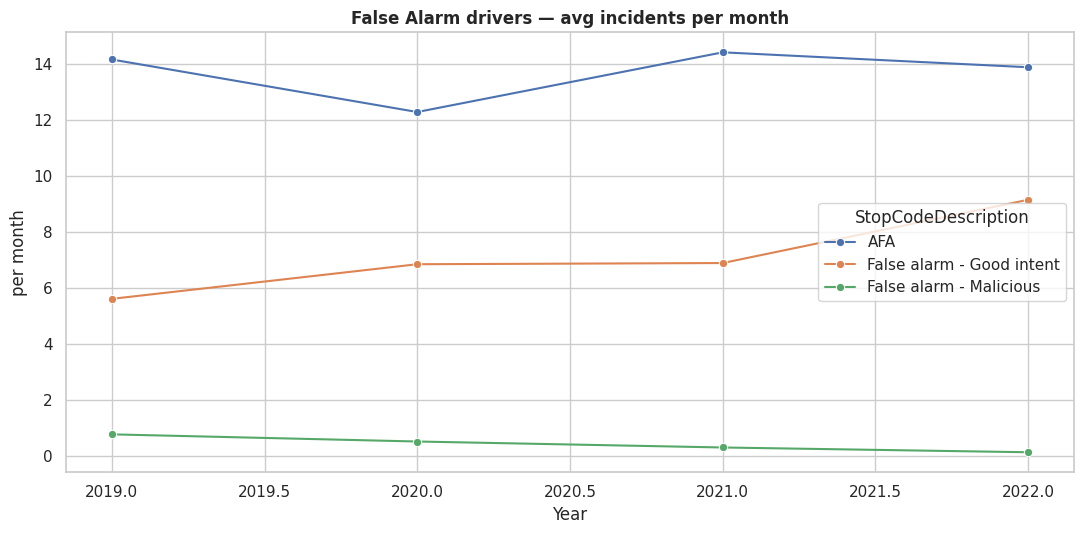

In [15]:
fa = dfi[dfi["IncidentGroup"]=="False Alarm"].copy()

# Top causes overall
fa_cause = fa["StopCodeDescription"].value_counts().head(12)
display(fa_cause.to_frame("count"))

# Trend by year (normalized by months present)
fa["Year"] = fa["DateOfCall_dt"].dt.year
cover = (fa.dropna(subset=["DateOfCall_dt"])
           .assign(ym=lambda x: x["DateOfCall_dt"].dt.to_period("M"))
           ["ym"].nunique())
trend = (fa.groupby(["Year","StopCodeDescription"], observed=True)
           .size().rename("n").reset_index())
trend["per_month"] = trend["n"] / cover

# Top 4 incidents
top4 = fa_cause.index[:4]
sns.lineplot(data=trend[trend["StopCodeDescription"].isin(top4)],
             x="Year", y="per_month", hue="StopCodeDescription", marker="o")
plt.title("False Alarm drivers — avg incidents per month"); plt.ylabel("per month")
plt.tight_layout(); plt.show()


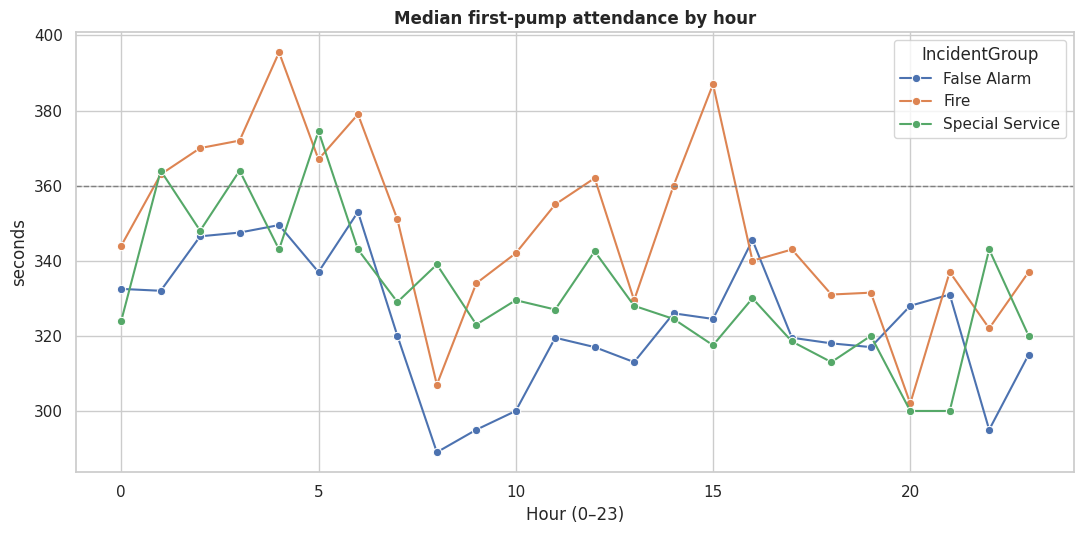

In [16]:
rt = (dfi.groupby(["Hour_num","IncidentGroup"], observed=True)
        ["FirstPumpArriving_AttendanceTime"]
        .median().reset_index(name="median_secs"))

sns.lineplot(data=rt, x="Hour_num", y="median_secs",
             hue="IncidentGroup", marker="o")
plt.axhline(360, ls="--", lw=1, color="gray")  # 6-min reference
plt.title("Median first-pump attendance by hour"); plt.ylabel("seconds"); plt.xlabel("Hour (0–23)")
plt.tight_layout(); plt.show()


,total_cost,median_cost,n
PropertyCategory,,,
Outdoor,2175736.0,352.0,1658
Dwelling,1928639.0,352.0,3856
Non Residential,934929.0,352.0,1851
Road Vehicle,567518.0,352.0,1063
Outdoor Structure,360422.0,352.0,528
Other Residential,226641.0,352.0,504
Rail Vehicle,3568.0,698.0,4
Aircraft,1056.0,1056.0,1


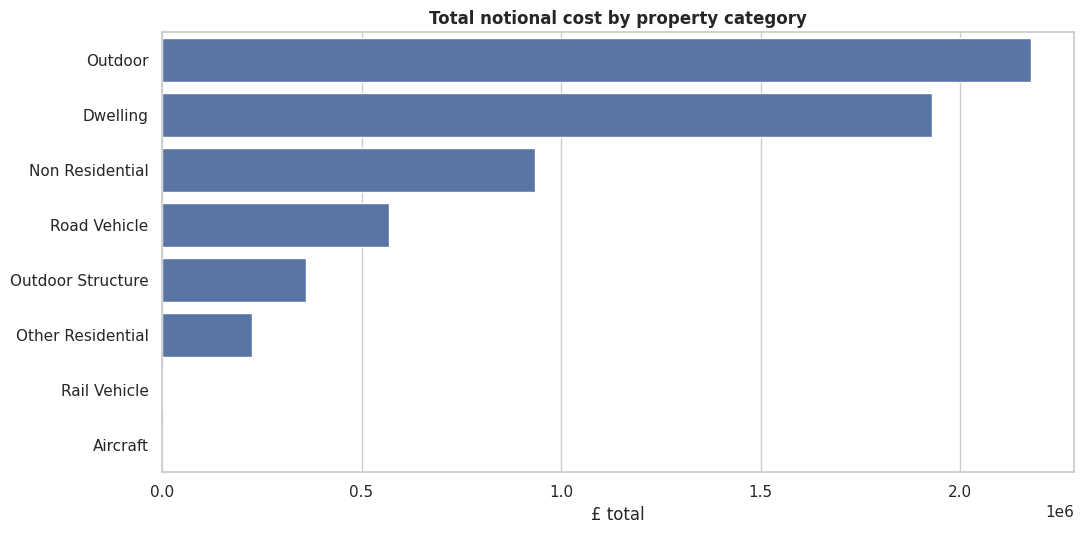

In [17]:
cost = (dfi.groupby("PropertyCategory", observed=True)["Notional Cost (£)"]
          .agg(total_cost="sum", median_cost="median", n="size")
          .sort_values("total_cost", ascending=False))
display(cost)

# Optional visual
sns.barplot(data=cost.reset_index(), y="PropertyCategory", x="total_cost")
plt.title("Total notional cost by property category"); plt.xlabel("£ total"); plt.ylabel("")
plt.tight_layout(); plt.show()


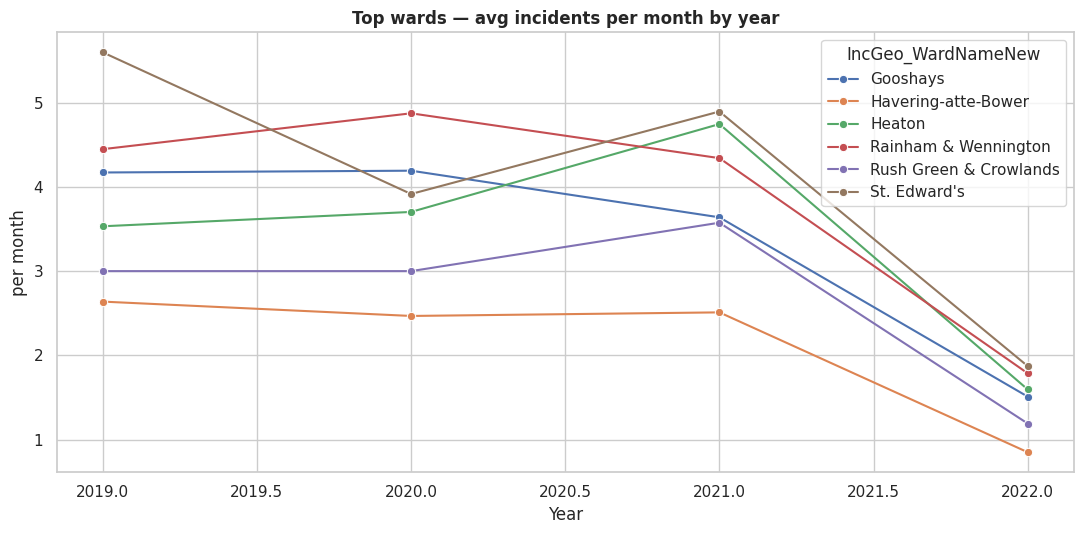

In [18]:
dfw = dfi.assign(Year=dfi["DateOfCall_dt"].dt.year)
months_present = (dfw.assign(ym=lambda x: x["DateOfCall_dt"].dt.to_period("M"))["ym"].nunique())

ward_year = (dfw.groupby(["IncGeo_WardNameNew","Year"], observed=True)
               .size().rename("n").reset_index())
ward_year["per_month"] = ward_year["n"] / months_present

top_wards = (ward_year.groupby("IncGeo_WardNameNew")["per_month"]
               .sum().nlargest(6).index)

sns.lineplot(data=ward_year[ward_year["IncGeo_WardNameNew"].isin(top_wards)],
             x="Year", y="per_month", hue="IncGeo_WardNameNew", marker="o")
plt.title("Top wards — avg incidents per month by year"); plt.ylabel("per month")
plt.tight_layout(); plt.show()


False alarms — drivers

AFA stays the dominant driver each year.

Good intent rises into 2022, while malicious drops to almost none.


Response times (first pump)

Fire medians with or exceed the 360-sec (6-min) line in the early morning (≈04–06) and mid-afternoon (≈15–16).
Check by station ground and day of week.

Cost

Outdoor and Dwelling account for the largest total notional cost (heavy tails still present).
A handful of very costly events likely drive a big share—worth isolating the top 1% to see what they are.

Spatial/temporal

Top wards’ per-month rates are stable through 2021, then dip in 2022 (expected—partial year).

June @ 21:00 spike (93 rows) is not normal variation.
2021-06-25 alone has 53 incidents.

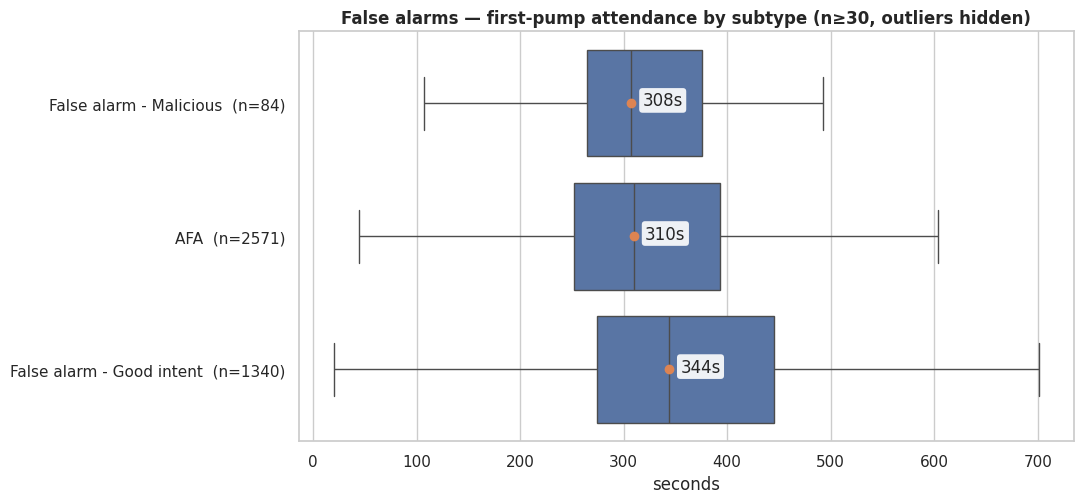

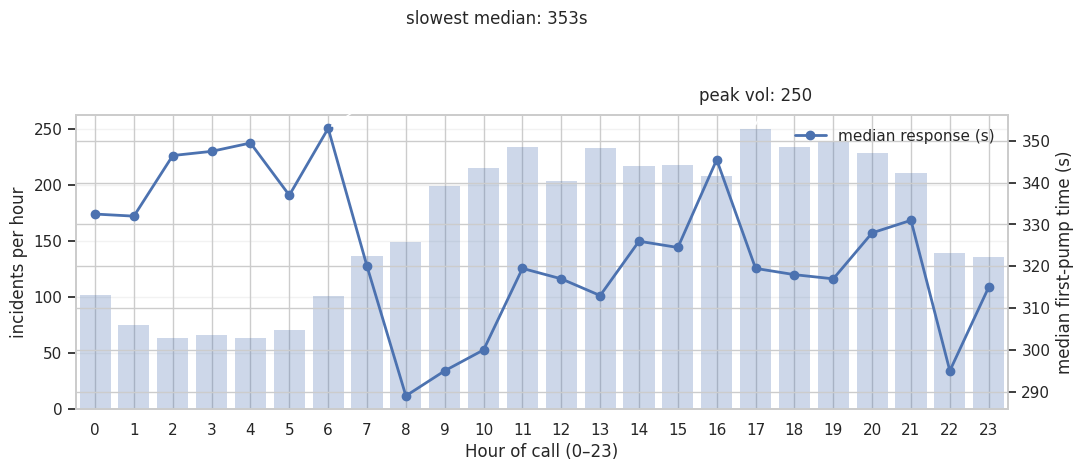

False-alarm subtypes — response stats (s) and %>6min:


,n,median,p25,p75,p90,sla_gt6m
StopCodeDescription,,,,,,
False alarm - Malicious,84,308.0,264.0,375.0,450.0,31.0
AFA,2571,310.0,252.0,393.0,485.0,32.8
False alarm - Good intent,1340,344.0,274.0,445.0,583.0,44.2


False alarms — by hour (count, median s, %>6min):


,count,median,sla_gt6m
hour,,,
0,102,332.0,39.2
1,75,332.0,37.3
2,64,346.0,45.3
3,66,348.0,43.9
4,64,350.0,42.2
5,71,337.0,28.2
6,101,353.0,48.5
7,137,320.0,34.3
8,149,289.0,28.2


Spearman(count, median s): SignificanceResult(statistic=np.float64(-0.4912858227912621), pvalue=np.float64(0.014769761268926568))

Kruskal–Wallis across subtypes: KruskalResult(statistic=np.float64(79.89654384651055), pvalue=np.float64(4.473896596181384e-18))

Pairwise Mann–Whitney (Holm-adjusted p):
                                                pair         p    p_holm
                    AFA vs False alarm - Good intent 6.221e-19 1.866e-18
False alarm - Malicious vs False alarm - Good intent  0.007604   0.01521
                      False alarm - Malicious vs AFA    0.8324    0.8324


In [19]:

# False alarms — first-pump attendance by subtype

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu, spearmanr
import itertools

fal = dfi[dfi["IncidentGroup"] == "False Alarm"].copy()


fal["FirstPumpArriving_AttendanceTime"] = pd.to_numeric(
    fal["FirstPumpArriving_AttendanceTime"], errors="coerce"
)


agg = (fal.groupby("StopCodeDescription", observed=True)["FirstPumpArriving_AttendanceTime"]
         .agg(n="count", median="median")
         .query("n >= 30")                # keep only subtypes with decent sample
         .sort_values("median"))

order  = agg.index.tolist()
yticks = [f"{lab}  (n={agg.loc[lab,'n']})" for lab in order]

plt.figure(figsize=(11, 5.2))
ax = sns.boxplot(
    data=fal[fal["StopCodeDescription"].isin(order)],
    y="StopCodeDescription", x="FirstPumpArriving_AttendanceTime",
    order=order, showfliers=False
)

ax.set_yticks(range(len(order)), labels=yticks)

ax.set_xlabel("seconds"); ax.set_ylabel("")
ax.set_title("False alarms — first-pump attendance by subtype (n≥30, outliers hidden)")


meds = agg["median"].to_numpy()
ax.scatter(meds, range(len(order)), s=36, zorder=3)
for i, m in enumerate(meds):
    ax.annotate(f"{int(round(m))}s", (m, i),
                xytext=(8, 2), textcoords="offset points",
                ha="left", va="center",
                bbox=dict(boxstyle="round,pad=.2", fc="white", ec="none", alpha=.9))
plt.tight_layout()
plt.show()

# False alarms — hourly volume (bars) & median first-pump time (line)

fal = fal.copy()
fal["hour"] = pd.to_numeric(fal["Hour_num"], errors="coerce").astype("Int64")

vol = (fal.dropna(subset=["hour"])
         .groupby("hour", observed=True)["IncidentNumber"].count().rename("count"))
med = (fal.dropna(subset=["hour"])
         .groupby("hour", observed=True)["FirstPumpArriving_AttendanceTime"]
         .median().rename("median"))

peak_h = int(vol.idxmax())
slow_h = int(med.idxmax())

fig, ax = plt.subplots(figsize=(11, 5.2))


ax.bar(vol.index, vol.values, alpha=0.28, edgecolor="none")
ax.set_xlim(-0.5, 23.5)
ax.set_xticks(range(0, 24, 1))
ax.set_xlabel("Hour of call (0–23)")
ax.set_ylabel("incidents per hour")
ax.grid(axis="y", alpha=0.25)


ax2 = ax.twinx()
line = ax2.plot(med.index, med.values, marker="o", linewidth=2,
                label="median response (s)")[0]
ax2.set_ylabel("median first-pump time (s)")
ax2.legend(handles=[line], loc="upper right", frameon=False)


ax.annotate(f"peak vol: {vol.loc[peak_h]}",
            xy=(peak_h, vol.loc[peak_h]),
            xytext=(peak_h, vol.max()*1.10),
            ha="center",
            arrowprops=dict(arrowstyle="->", lw=1))

ax2.annotate(f"slowest median: {int(med.loc[slow_h])}s",
             xy=(slow_h, med.loc[slow_h]),
             xytext=(min(slow_h+2, 22.5), med.loc[slow_h] + 25),
             ha="left",
             arrowprops=dict(arrowstyle="->", lw=1))

fig.tight_layout()
plt.show()


# Table per subtype + SLA breaches

def q(s, p): return s.quantile(p)

sub_tbl = (fal.groupby("StopCodeDescription", observed=True)["FirstPumpArriving_AttendanceTime"]
             .agg(n="count",
                  median="median",
                  p25=lambda s: q(s,.25),
                  p75=lambda s: q(s,.75),
                  p90=lambda s: q(s,.90),
                  sla_gt6m=lambda s: (s > 360).mean()*100)
             .query("n >= 30")
             .sort_values("median")
             .round({"median":0,"p25":0,"p75":0,"p90":0,"sla_gt6m":1}))
print("False-alarm subtypes — response stats (s) and %>6min:")
display(sub_tbl)


# Hour-of-day table + correlation

by_hour = (pd.concat([vol, med], axis=1)
             .assign(sla_gt6m=(fal.assign(gt=fal["FirstPumpArriving_AttendanceTime"]>360)
                                  .groupby("hour")["gt"].mean()*100))
            ).round({"median":0,"sla_gt6m":1}).astype({"count":int})
print("False alarms — by hour (count, median s, %>6min):")
display(by_hour)

print("Spearman(count, median s):", spearmanr(by_hour["count"], by_hour["median"]))


# Are subtype medians different? (Kruskal + pairwise Holm)

labels = sub_tbl.index.tolist()
groups = [fal.loc[fal["StopCodeDescription"].eq(lab),
                  "FirstPumpArriving_AttendanceTime"].dropna().values
          for lab in labels]

if len(groups) >= 2:
    print("\nKruskal–Wallis across subtypes:", kruskal(*groups))

    pairs, pvals = [], []
    for i, j in itertools.combinations(range(len(labels)), 2):
        stat, p = mannwhitneyu(groups[i], groups[j], alternative="two-sided")
        pairs.append(f"{labels[i]} vs {labels[j]}"); pvals.append(p)
    # Holm correction
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m)
    for rank, idx in enumerate(order):
        adj[idx] = min(pvals[idx] * (m - rank), 1.0)

    pair_tbl = (pd.DataFrame({"pair": pairs, "p": pvals, "p_holm": adj})
                  .sort_values("p_holm"))
    print("\nPairwise Mann–Whitney (Holm-adjusted p):")
    print(pair_tbl.to_string(index=False, float_format=lambda x: f"{x:.4g}"))


What’s driving slower false-alarm responses?

Fastest medians: 08:00–10:00 → 289–300s and 22:00 → 295s with the lowest SLA>6min (25.2%).

Volume peak: 17:00 (n=250). Despite high volume, median is 320s (not the slowest).

Volume vs speed: Spearman between hourly count and median is –0.49 (p=0.015) → busier hours tend to have slightly faster medians, so the slow periods are not explained by simple demand pressure.

Takeaway: The worst time window is pre-work early morning (≈02:00–06:00) and a late-afternoon (≈16:00). Peak volume at 17:00 doesn’t degrade medians, so the slowdowns are likely operational/time-of-day factors (cover, traffic, handovers, etc.), not load.

/tmp/ipython-input-1011324194.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(pt):


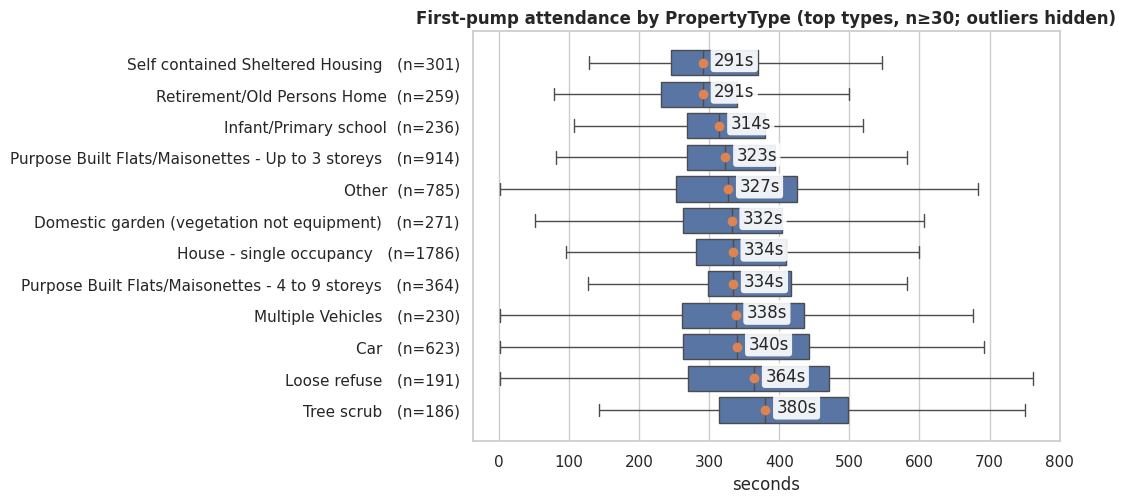

In [20]:
# PropertyType — first-pump attendance time by type (top by volume) ---
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

dfp = dfi.copy()

# Group rare PropertyType into "Other"
THRESH = 20
pt = dfp["PropertyType"]
if pd.api.types.is_categorical_dtype(pt):

    rare = pt.value_counts()[pt.value_counts() < THRESH].index
    dfp["PropertyType_grp"] = pt.cat.add_categories(["Other"]).where(~pt.isin(rare), "Other")
else:
    freq = pt.value_counts()
    rare = freq[freq < THRESH].index
    dfp["PropertyType_grp"] = pt.where(~pt.isin(rare), "Other").astype("category")

TOPK = 12
top_types = (dfp["PropertyType_grp"].value_counts().head(TOPK).index)
sub = dfp[dfp["PropertyType_grp"].isin(top_types)].copy()


agg = (sub.groupby("PropertyType_grp", observed=True)["FirstPumpArriving_AttendanceTime"]
         .agg(n="count", median="median")
         .query("n >= 30")
         .sort_values("median"))
order = agg.index.tolist()
yticks = [f"{t}  (n={agg.loc[t,'n']})" for t in order]

plt.figure(figsize=(11, 5.2))
ax = sns.boxplot(
    data=sub[sub["PropertyType_grp"].isin(order)],
    y="PropertyType_grp", x="FirstPumpArriving_AttendanceTime",
    order=order, showfliers=False
)

ax.set_yticks(range(len(order)), labels=yticks)


meds = agg["median"].to_numpy()
ax.scatter(meds, range(len(order)), s=36, zorder=3)
for i, m in enumerate(meds):
    ax.annotate(f"{int(round(m))}s", (m, i), xytext=(8, 2), textcoords="offset points",
                ha="left", va="center",
                bbox=dict(boxstyle="round,pad=.2", fc="white", ec="none", alpha=.9))

ax.set_xlabel("seconds"); ax.set_ylabel("")
ax.set_title("First-pump attendance by PropertyType (top types, n≥30; outliers hidden)")
plt.tight_layout(); plt.show()


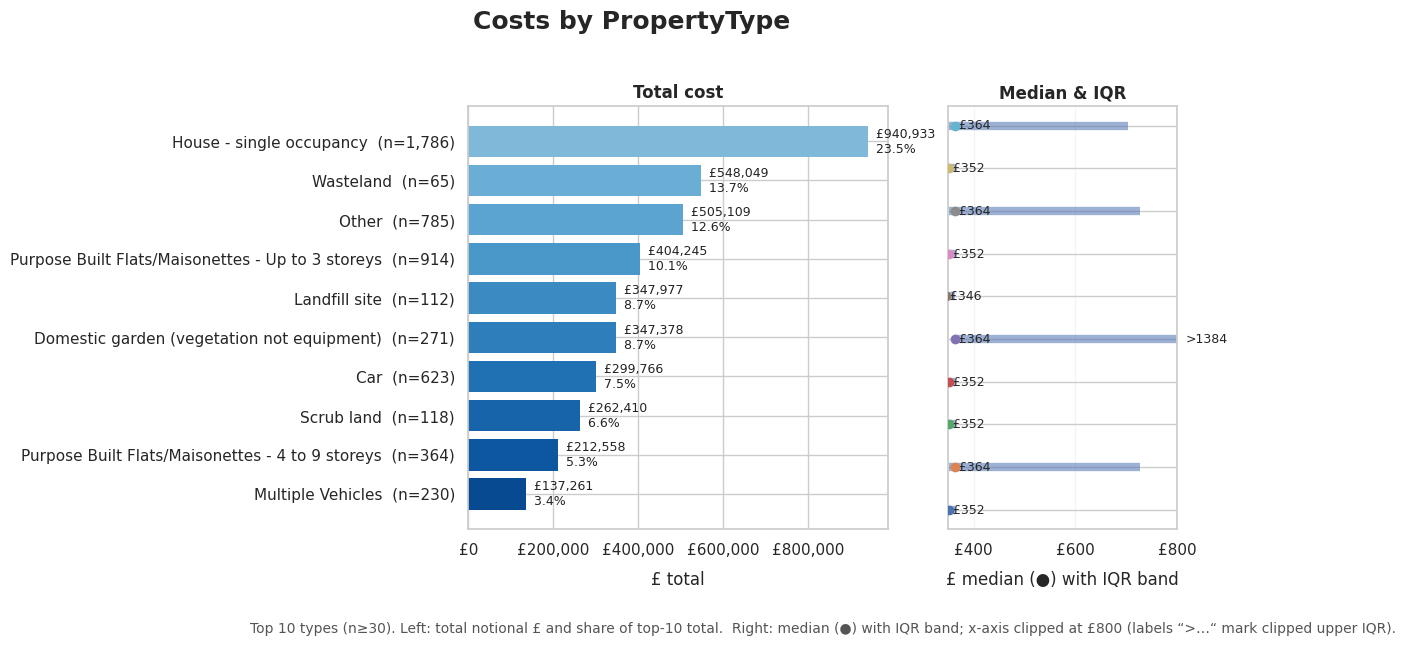

In [21]:
# Costs by PropertyType

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

dfc = dfi.copy()


if "PropertyType_grp" in dfc.columns:
    pt_col = "PropertyType_grp"
else:
    pt_col = "PropertyType"
    freq = dfc[pt_col].value_counts()
    rare = freq[freq < 20].index
    if pd.api.types.is_categorical_dtype(dfc[pt_col]):
        dfc[pt_col] = dfc[pt_col].astype(str)
    dfc[pt_col] = np.where(dfc[pt_col].isin(rare), "Other", dfc[pt_col])

dfc = dfc.dropna(subset=["Notional Cost (£)"])


g = (dfc.groupby(pt_col, observed=True)["Notional Cost (£)"]
        .agg(n="count",
             total="sum",
             p25=lambda s: np.percentile(s, 25),
             median="median",
             p75=lambda s: np.percentile(s, 75))
        .reset_index()
        .rename(columns={pt_col: "PropertyType"}))

g = g.query("n >= 30").sort_values("total", ascending=False)
top_k = 10
top = g.head(top_k).copy()
top["share"] = top["total"] / top["total"].sum()

fmt_pounds0 = FuncFormatter(lambda x, pos: f"£{x:,.0f}")

fig = plt.figure(figsize=(12.8, 7.2))
gs  = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[18, 2],
    width_ratios=[2.2, 1.2]
)

axL = fig.add_subplot(gs[0, 0])
axR = fig.add_subplot(gs[0, 1])
axCap = fig.add_subplot(gs[1, :])
axCap.axis("off")

fig.suptitle("Costs by PropertyType", fontsize=18, fontweight="semibold", y=0.98)

order = top["PropertyType"].tolist()
ypos  = np.arange(len(order))

# ---- Left: TOTAL notional cost ----
colors = plt.cm.Blues(np.linspace(0.45, 0.90, len(order)))
axL.barh(ypos, top["total"].values, color=colors, edgecolor="none")
axL.set_yticks(ypos, labels=[f"{lab}  (n={int(n):,})"
                             for lab, n in zip(order, top["n"])])
axL.invert_yaxis()
axL.xaxis.set_major_formatter(fmt_pounds0)
axL.set_xlabel("£ total", labelpad=10)
axL.set_title("Total cost", pad=6)

for i, (val, sh) in enumerate(zip(top["total"], top["share"])):
    axL.text(val, i, f"  £{val:,.0f}\n  {sh*100:,.1f}%",
             va="center", ha="left", fontsize=9, color="#222")

# ---- Right: MEDIAN with IQR band (clipped at £800) ----
med  = top.set_index("PropertyType").loc[order]
y    = np.arange(len(order))
cap  = 800
xmin = 350
axR.set_xlim(xmin, cap)

for i, (p25, m, p75) in enumerate(med[["p25","median","p75"]].to_numpy()):
    lo = max(p25, xmin); hi = min(p75, cap)
    axR.hlines(i, lo, hi, linewidth=6, alpha=0.55)
    axR.plot(m, i, "o", ms=6, zorder=3)
    axR.text(m, i, f" £{m:,.0f}", va="center", ha="left", fontsize=9)
    if p75 > cap:
        axR.annotate(f">{int(round(p75))}",
                     xy=(cap, i), xytext=(6, 0),
                     textcoords="offset points", va="center", fontsize=9)

axR.set_yticks(y, labels=[""]*len(order))
axR.xaxis.set_major_formatter(fmt_pounds0)
axR.set_xlabel("£ median (●) with IQR band", labelpad=10)
axR.set_title("Median & IQR", pad=6)
axR.grid(axis="x", alpha=0.2)


cap_text = (
    "Top 10 types (n≥30). Left: total notional £ and share of top-10 total.  "
    "Right: median (●) with IQR band; x-axis clipped at £800 (labels “>…“ mark clipped upper IQR)."
)
axCap.text(0.5, 0.55, cap_text, ha="center", va="center", fontsize=10, color="#555")

plt.tight_layout(rect=[0, 0.06, 1, 0.96])
plt.show()


Total cost is volume-driven. House – single occupancy contributes the most (~£0.94m; 23.5% of the top-10 total) because it’s the most common type. Wasteland and Other also add large totals, reflecting frequent outdoor incidents.

Unit cost is flat. Median notional cost per incident is ~£350 across types (right panel). That’s expected—cost mostly tracks pump-hours, not property type.

Where jobs run long. Wider IQR/tails (e.g., Domestic garden, Other, Flats 4–9 storeys) indicate more long-duration incidents; labels like “>1384” mark clipped high tails.

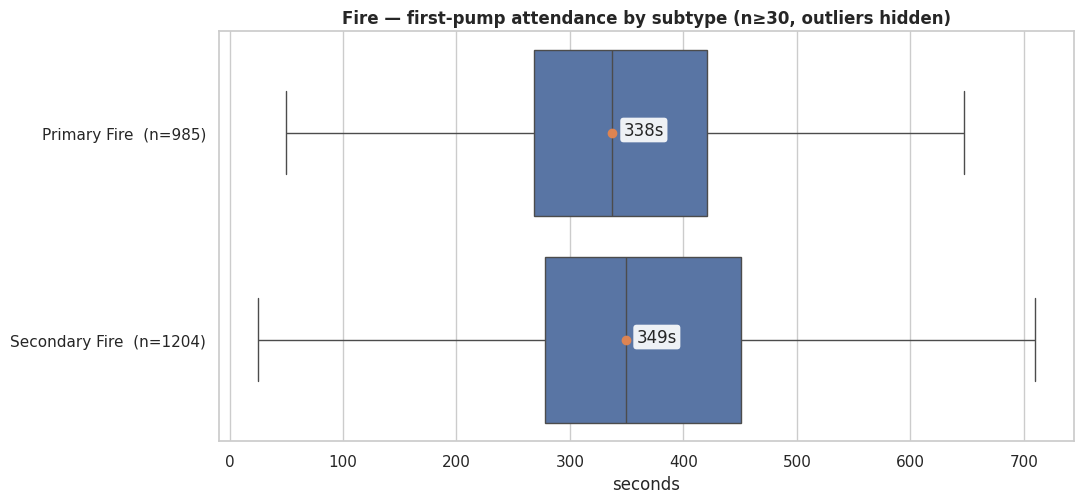

,n,median,p25,p75,p90,sla_gt6m
StopCodeDescription,,,,,,
Primary Fire,985,337.5,268.0,421.0,537.8,40.6
Secondary Fire,1204,349.0,278.0,451.0,611.8,46.9


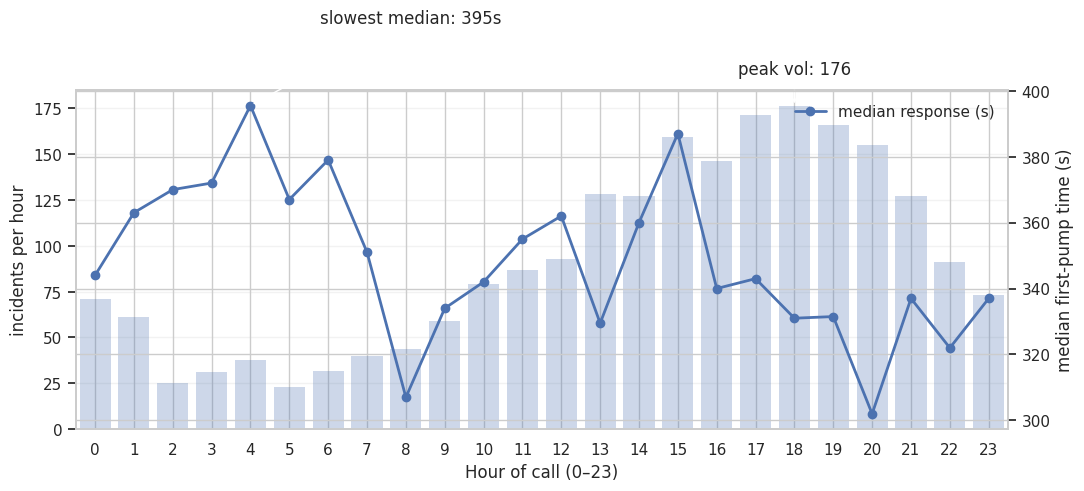

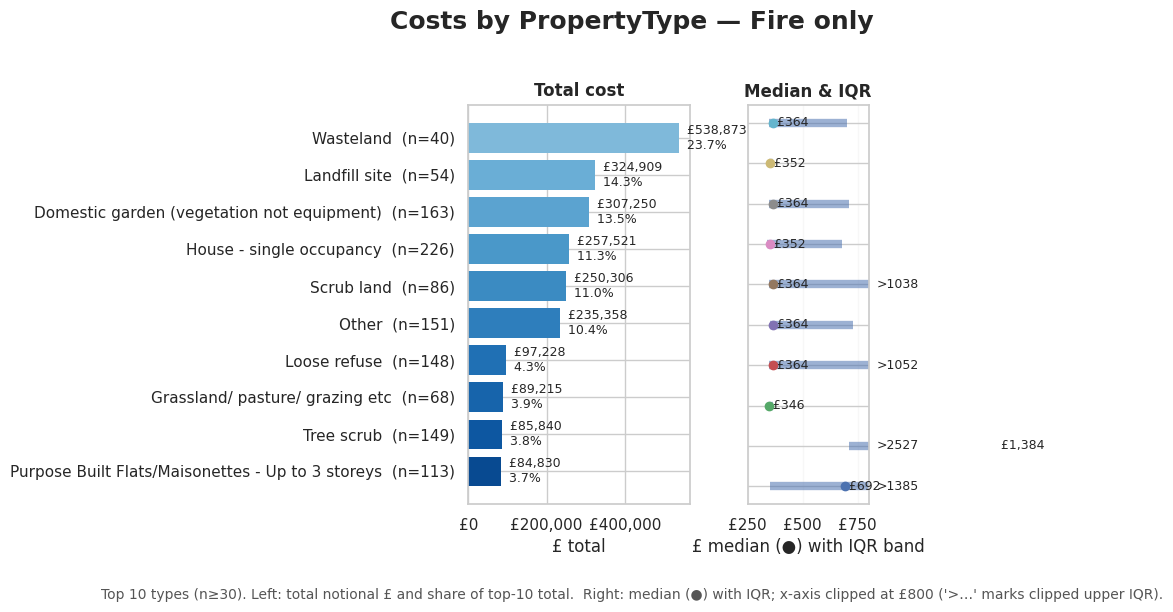

In [22]:
# FIRE — subtype response, hourly profile, and costs by PropertyType

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fire = dfi[dfi["IncidentGroup"] == "Fire"].copy()

# First-pump attendance by Fire subtype (StopCodeDescription)
agg = (fire.groupby("StopCodeDescription", observed=True)["FirstPumpArriving_AttendanceTime"]
         .agg(n="count", median="median")
         .query("n >= 30")     # keep only well-sampled subtypes
         .sort_values("median"))
order  = agg.index.tolist()
yticks = [f"{lab}  (n={agg.loc[lab,'n']})" for lab in order]

plt.figure(figsize=(11, 5.2))
ax = sns.boxplot(
    data=fire[fire["StopCodeDescription"].isin(order)],
    y="StopCodeDescription", x="FirstPumpArriving_AttendanceTime",
    order=order, showfliers=False
)
ax.set_yticks(range(len(order)), labels=yticks)
ax.set_xlabel("seconds"); ax.set_ylabel("")
ax.set_title("Fire — first-pump attendance by subtype (n≥30, outliers hidden)")


meds = agg["median"].to_numpy()
ax.scatter(meds, range(len(order)), s=36, zorder=3)
for i, m in enumerate(meds):
    ax.annotate(f"{int(round(m))}s", (m, i),
                xytext=(8, 2), textcoords="offset points",
                ha="left", va="center",
                bbox=dict(boxstyle="round,pad=.2", fc="white", ec="none", alpha=.9))
plt.tight_layout()
plt.show()

# Table (incl. % > 6 min SLA)
sla = (fire.assign(gt6=(fire["FirstPumpArriving_AttendanceTime"] > 360))
           .groupby("StopCodeDescription", observed=True)
           .agg(n=("IncidentNumber","count"),
                median=("FirstPumpArriving_AttendanceTime","median"),
                p25 =("FirstPumpArriving_AttendanceTime",lambda s: np.percentile(s,25)),
                p75 =("FirstPumpArriving_AttendanceTime",lambda s: np.percentile(s,75)),
                p90 =("FirstPumpArriving_AttendanceTime",lambda s: np.percentile(s,90)),
                sla_gt6m=("gt6","mean"))
           .query("n>=30")
           .sort_values("median"))
display(sla.assign(sla_gt6m=(sla["sla_gt6m"]*100).round(1)))

# Hourly profile — volume (bars) & median response (line)
fire["hour"] = fire["Hour_num"].astype(int)
vol = fire.groupby("hour", observed=True)["IncidentNumber"].count().rename("count")
med = fire.groupby("hour", observed=True)["FirstPumpArriving_AttendanceTime"].median().rename("median")

peak_h = int(vol.idxmax())
slow_h = int(med.idxmax())

fig, ax = plt.subplots(figsize=(11, 5.2))
ax.bar(vol.index, vol.values, alpha=0.28, edgecolor="none")
ax.set_xlim(-0.5, 23.5)
ax.set_xticks(range(0, 24, 1))
ax.set_xlabel("Hour of call (0–23)")
ax.set_ylabel("incidents per hour")
ax.grid(axis="y", alpha=0.25)

ax2 = ax.twinx()
line = ax2.plot(med.index, med.values, marker="o", linewidth=2, label="median response (s)")[0]
ax2.set_ylabel("median first-pump time (s)")
ax2.legend(loc="upper right", frameon=False)

ax.annotate(f"peak vol: {vol.loc[peak_h]}", xy=(peak_h, vol.loc[peak_h]),
            xytext=(peak_h, vol.max()*1.10), ha="center",
            arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate(f"slowest median: {int(med.loc[slow_h])}s", xy=(slow_h, med.loc[slow_h]),
             xytext=(min(slow_h+1.8, 22.5), med.loc[slow_h] + 25),
             ha="left", arrowprops=dict(arrowstyle="->", lw=1))
fig.tight_layout()
plt.show()

# Costs by PropertyType (Fire only)
def plot_costs_by_propertytype(df, title="Costs by PropertyType — Fire only"):
    dfc = df.copy()

    if "PropertyType_grp" in dfc.columns:
        pt_col = "PropertyType_grp"
    else:
        pt_col = "PropertyType"
        freq = dfc[pt_col].value_counts()
        rare = freq[freq < 20].index
        if pd.api.types.is_categorical_dtype(dfc[pt_col]):
            dfc[pt_col] = dfc[pt_col].astype(str)
        dfc[pt_col] = np.where(dfc[pt_col].isin(rare), "Other", dfc[pt_col])

    dfc = dfc.dropna(subset=["Notional Cost (£)"])
    g = (dfc.groupby(pt_col, observed=True)["Notional Cost (£)"]
            .agg(n="count",
                 total="sum",
                 p25=lambda s: np.percentile(s,25),
                 median="median",
                 p75=lambda s: np.percentile(s,75))
            .reset_index()
            .rename(columns={pt_col: "PropertyType"}))
    g = g.query("n >= 30").sort_values("total", ascending=False)
    top = g.head(10).copy()
    top["share"] = top["total"] / top["total"].sum()

    fmt_pounds0 = FuncFormatter(lambda x, pos: f"£{x:,.0f}")
    fig, (axL, axR) = plt.subplots(
        ncols=2, figsize=(12.8, 6.2), gridspec_kw={"width_ratios": [2.2, 1.2]}
    )
    fig.suptitle(title, y=0.97, fontsize=18, fontweight="semibold")

    order = top["PropertyType"].tolist()
    y = np.arange(len(order))
    colors = plt.cm.Blues(np.linspace(0.45, 0.90, len(order)))

    # Left: total £ + share
    axL.barh(y, top["total"].values, color=colors, edgecolor="none")
    axL.set_yticks(y, labels=[f"{lab}  (n={int(n):,})" for lab, n in zip(order, top["n"])])
    axL.invert_yaxis()
    axL.xaxis.set_major_formatter(fmt_pounds0)
    axL.set_xlabel("£ total")
    axL.set_title("Total cost")
    for i, (val, sh) in enumerate(zip(top["total"], top["share"])):
        axL.text(val, i, f"  £{val:,.0f}\n  {sh*100:,.1f}%", va="center", ha="left", fontsize=9)

    # Right: median + IQR band (clipped)
    med = top.set_index("PropertyType").loc[order]
    xmin, cap = 250, 800
    axR.set_xlim(xmin, cap)
    for i, (p25, m, p75) in enumerate(med[["p25","median","p75"]].to_numpy()):
        lo = max(p25, xmin); hi = min(p75, cap)
        axR.hlines(i, lo, hi, linewidth=6, alpha=0.55)
        axR.plot(m, i, "o", ms=6, zorder=3)
        axR.text(m, i, f" £{m:,.0f}", va="center", ha="left", fontsize=9)
        if p75 > cap:
            axR.annotate(f">{int(round(p75))}", xy=(cap, i), xytext=(6, 0),
                         textcoords="offset points", va="center", fontsize=9)
    axR.set_yticks(y, labels=[""]*len(order))
    axR.xaxis.set_major_formatter(fmt_pounds0)
    axR.set_xlabel("£ median (●) with IQR band")
    axR.set_title("Median & IQR")
    axR.grid(axis="x", alpha=0.15)


    fig.text(0.5, 0.02,
             "Top 10 types (n≥30). Left: total notional £ and share of top-10 total.  "
             "Right: median (●) with IQR; x-axis clipped at £800 ('>…' marks clipped upper IQR).",
             ha="center", fontsize=10, color="#555")
    fig.tight_layout(rect=[0, 0.06, 1, 0.95])
    plt.show()

plot_costs_by_propertytype(fire)


SLA risk: Secondary fires breach 6-min SLA ~ 47%, higher than primary (~ 41%).

When it hurts: 16:00–19:00 = peak demand and slowest response → double hit on performance.

Cost drivers: Spend is concentrated in outdoor risks—wasteland, landfill, domestic gardens—despite similar median job costs. Heavy tail losses inflate totals.

Residential impact: House (single occupancy) still a major share of total £, but not the top driver of spikes.

Operational lever: Improve afternoon cover & routing; prioritize secondary-fire tactics.

Prevention focus: Target wasteland/landfill/garden ignition sources (clearing, patrols, community comms) to cut both volume and tail costs.

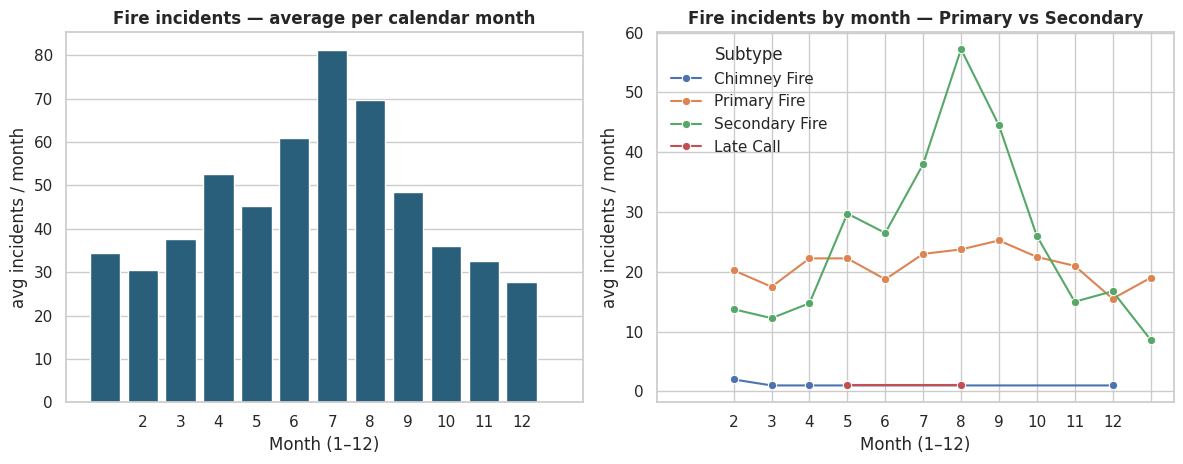

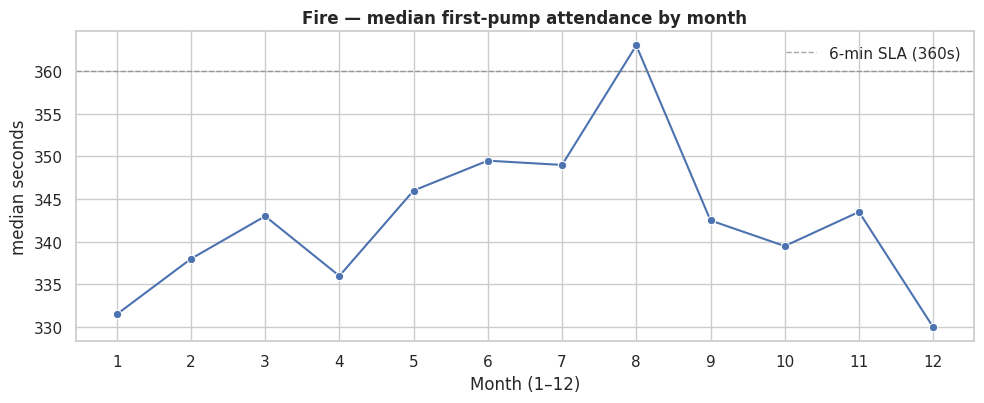

In [23]:
# Fire by month (normalized across years)
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
sns.set_context("notebook"); sns.set_style("whitegrid")

fire = dfi[dfi["IncidentGroup"] == "Fire"].copy()
fire["Year"]  = fire["DateOfCall_dt"].dt.year.astype("Int64")
fire["Month"] = fire["DateOfCall_dt"].dt.month.astype("Int64")

# Counts per Year×Month (handles partial years), then average across years
ym_cnt  = (fire.groupby(["Year","Month"], observed=True)
              .size().rename("n").reset_index())
avg_m   = (ym_cnt.groupby("Month", observed=True)["n"]
                 .mean().rename("per_month").reset_index())

# By subtype (Primary vs Secondary)
ym_sub  = (fire.groupby(["Year","Month","StopCodeDescription"], observed=True)
              .size().rename("n").reset_index())
avg_sub = (ym_sub.groupby(["Month","StopCodeDescription"], observed=True)["n"]
                 .mean().rename("per_month").reset_index())

# Median first-pump time per month (Fire only)
med_resp = (fire.groupby("Month", observed=True)["FirstPumpArriving_AttendanceTime"]
               .median().rename("median_s").reset_index())

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4.8), sharex=True)

# A) Volume — average incidents per calendar month (bars)
sns.barplot(data=avg_m, x="Month", y="per_month", ax=ax1, color=sns.color_palette("crest")[4])
ax1.set_title("Fire incidents — average per calendar month")
ax1.set_xlabel("Month (1–12)"); ax1.set_ylabel("avg incidents / month")
ax1.set_xticks(range(1,13))

# B) Split by subtype — average per month (lines)
sns.lineplot(data=avg_sub, x="Month", y="per_month",
             hue="StopCodeDescription", marker="o", ax=ax2)
ax2.set_title("Fire incidents by month — Primary vs Secondary")
ax2.set_xlabel("Month (1–12)"); ax2.set_ylabel("avg incidents / month")
ax2.set_xticks(range(1,13)); ax2.legend(title="Subtype", frameon=False)

plt.tight_layout(); plt.show()

# C) Median first-pump time per month (dashed SLA at 360s)
plt.figure(figsize=(10,4.2))
sns.lineplot(data=med_resp, x="Month", y="median_s", marker="o")
plt.axhline(360, ls="--", lw=1, color="gray", alpha=.7, label="6-min SLA (360s)")
plt.title("Fire — median first-pump attendance by month")
plt.xlabel("Month (1–12)"); plt.ylabel("median seconds")
plt.xticks(range(1,13))
plt.legend(frameon=False); plt.tight_layout(); plt.show()


Clear seasonality. Fire incidents climb steadily from spring, peaking in July–August (~80/month in total), then tail off into winter.

Who’s driving the peak? The split shows it’s Secondary Fires (grass, refuse, scrub, wasteland) that surge in summer. Primary Fires stay relatively steady with only a mild summer uptick. Chimney/late-call are negligible.

Response performance. Median first-pump time is ~330–350s most months (under the 6-min SLA). August nudges above SLA, coinciding with the demand peak.

What to do about it (concise actions)
Seasonal resourcing (July–Aug).

Put surge cover on the run (overtime/rostered leave caps).

Dynamic cover moves to parks, wasteland, and estates that historically spike.

Pre-plan mutual aid triggers and wildfire unit availability on high Fire Severity Index days.

Targeted prevention (May–Aug).

BBQ/campfire & fireworks messaging, youth engagement, and bin/grass management with councils.

Patrols & rapid intervention in known hotspots (wasteland, scrub land, domestic gardens).

Temporary public bins/skip fire controls around events and school holidays.

Ops efficiency.

Keep training/maintenance off the August peak where possible.

Use real-time thresholds: when hourly incidents > X, auto-reposition appliances and throttle non-urgent activities.

Review call handling triage to keep first-pump wheels rolling during the 16:00–20:00 shoulder where volumes are high.

Busiest fire hour(s): [18]  |  incidents: 176

Busiest hour by fire subtype:


,StopCodeDescription,hour,count
0,Secondary Fire,20,103
1,Primary Fire,15,76
2,Chimney Fire,19,3
3,Late Call,11,1


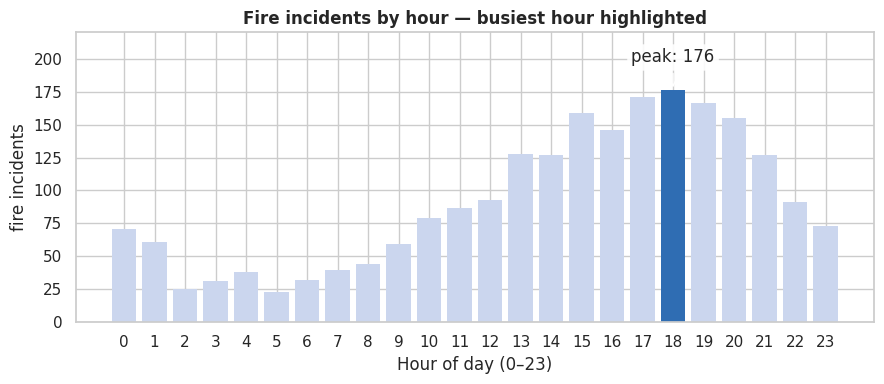

In [24]:
# Busiest time for FIRE incidents (overall + by subtype) with a clear plot

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
sns.set_context("notebook"); sns.set_style("whitegrid")

fire = dfi.loc[dfi["IncidentGroup"] == "Fire"].copy()

fire["hour"] = pd.to_numeric(fire["Hour_num"], errors="coerce").astype("Int64")
fire = fire[fire["hour"].between(0, 23)]

# Overall busiest hour(s)
cnt = (fire.groupby("hour", observed=True)["IncidentNumber"]
          .count()
          .reindex(range(24), fill_value=0))        # ensure all hours shown

peak_val   = int(cnt.max())
peak_hours = [int(h) for h, v in cnt.items() if v == peak_val]
print(f"Busiest fire hour(s): {peak_hours}  |  incidents: {peak_val}")

# Busiest hour by fire subtype
by_sub = (fire.groupby(["StopCodeDescription","hour"], observed=True)
              .size().rename("count").reset_index())

idx = by_sub.groupby("StopCodeDescription")["count"].idxmax()
top_by_sub = (by_sub.loc[idx].sort_values("count", ascending=False)
              .reset_index(drop=True))
print("\nBusiest hour by fire subtype:")
display(top_by_sub)

# Fire incidents by hour
colors = ["#cbd6ee"] * 24
for h in peak_hours: colors[h] = "#2f6db3"

plt.figure(figsize=(9,4))
ax = plt.gca()
ax.bar(cnt.index, cnt.values, color=colors, edgecolor="none")
ax.set_xticks(range(24))
ax.set_xlabel("Hour of day (0–23)")
ax.set_ylabel("fire incidents")
ax.set_title("Fire incidents by hour — busiest hour highlighted")

top = cnt.max()
ax.set_ylim(0, top * 1.25)

for i, h in enumerate(peak_hours):
    x_stagger = h + (i - (len(peak_hours)-1)/2) * 0.35
    ax.annotate(f"peak: {cnt.loc[h]}",
                xy=(h, cnt.loc[h]),
                xytext=(x_stagger, top * 1.12),
                ha="center",
                arrowprops=dict(arrowstyle="->", lw=1),
                bbox=dict(boxstyle="round,pad=.25", fc="white", ec="none", alpha=.9))

plt.tight_layout()
plt.show()


Busiest overall hour: 18:00 with 176 incidents. The evening window 15:00–21:00 is the sustained surge.

By subtype

Secondary Fire: peaks 20:00 (103) — drives the evening spike (likely outdoor/grass/bin fires).

Primary Fire: peaks 15:00 (76) — earlier, building/vehicle fires.

Chimney Fire: tiny volume, 19:00 (3).

Late Call: negligible, 11:00 (1).

Resource cover: ensure strongest appliance availability and officer cover 15:00–21:00, with particular attention to 18:00–20:00.

In [25]:
!pip -q install gower scikit-learn-extra umap-learn

In [26]:
hav.head()

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls,__sheet,__row_in_sheet,DateOfCall_dt,TimeOfCall_td,HourOfCall_num
34,000139-01012019,01 Jan 2019,2019,00:45:13,0,False Alarm,AFA,NaN,Non Residential,Multi-Storey car park,...,1.0,1.0,1.0,333.0,1.0,Sheet1,34,2019-01-01,0 days 00:45:13,0
48,000170-01012019,01 Jan 2019,2019,01:01:23,1,Fire,Secondary Fire,NaN,Outdoor Structure,Common external bin storage area,...,1.0,1.0,1.0,333.0,1.0,Sheet1,48,2019-01-01,0 days 01:01:23,1
86,000270-01012019,01 Jan 2019,2019,02:09:05,2,Fire,Secondary Fire,NaN,Outdoor Structure,Fence,...,1.0,1.0,1.0,333.0,2.0,Sheet1,86,2019-01-01,0 days 02:09:05,2
179,000458-01012019,01 Jan 2019,2019,13:52:52,13,False Alarm,AFA,NaN,Other Residential,Retirement/Old Persons Home,...,2.0,2.0,1.0,333.0,1.0,Sheet1,179,2019-01-01,0 days 13:52:52,13
285,000653-01012019,01 Jan 2019,2019,22:49:06,22,Fire,Secondary Fire,NaN,Outdoor Structure,Large refuse/rubbish container (eg skip/ paladin),...,1.0,1.0,1.0,333.0,1.0,Sheet1,285,2019-01-01,0 days 22:49:06,22


Shape: (9465, 44)

Missing values:
 SecondPumpArriving_AttendanceTime         6617
SecondPumpArriving_DeployedFromStation    6617
SpecialServiceType                        6197
Postcode_full                             3922
Longitude                                 3922
Latitude                                  3922
Easting_m                                 3922
Northing_m                                3922
FirstPumpArriving_DeployedFromStation      569
FirstPumpArriving_AttendanceTime           569
NumPumpsAttending                          273
NumStationsWithPumpsAttending              273
PumpHoursRoundUp                            66
Notional Cost (£)                           66
PumpCount                                   62
dtype: int64


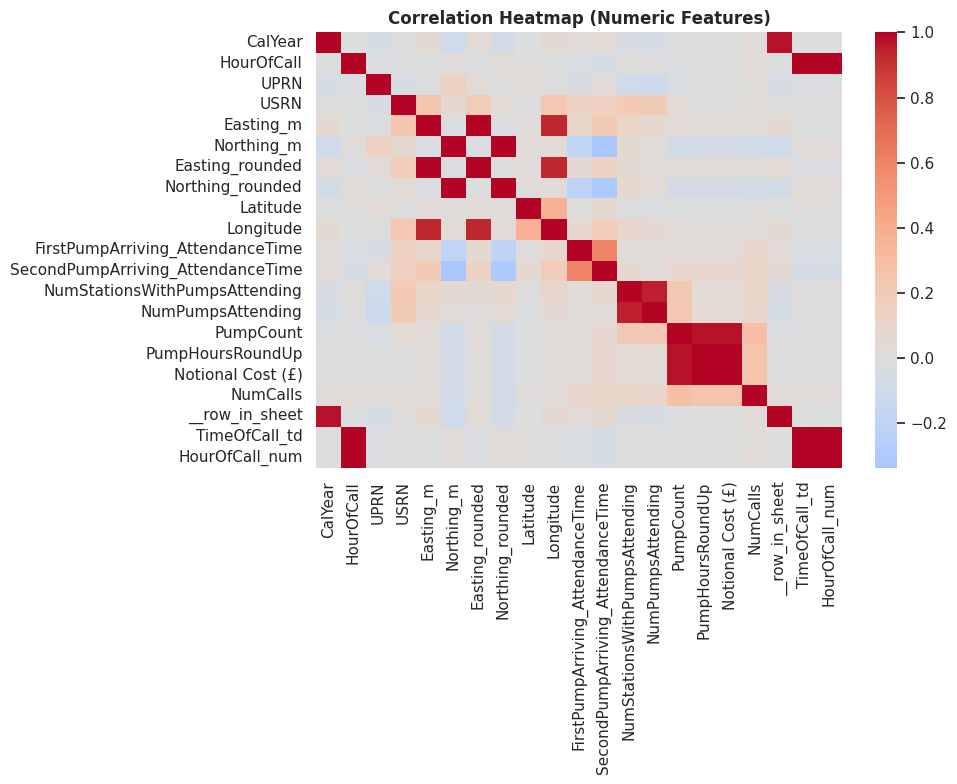

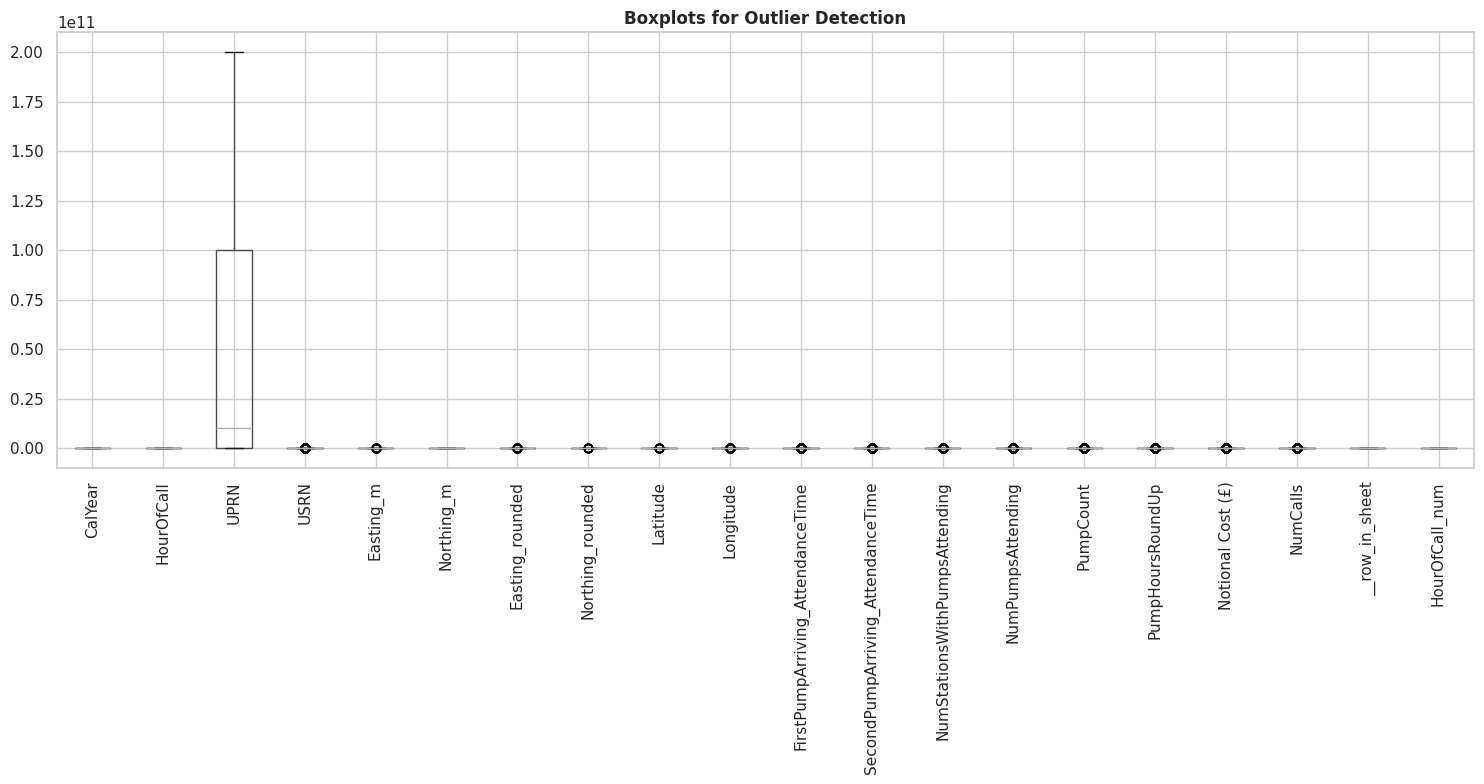

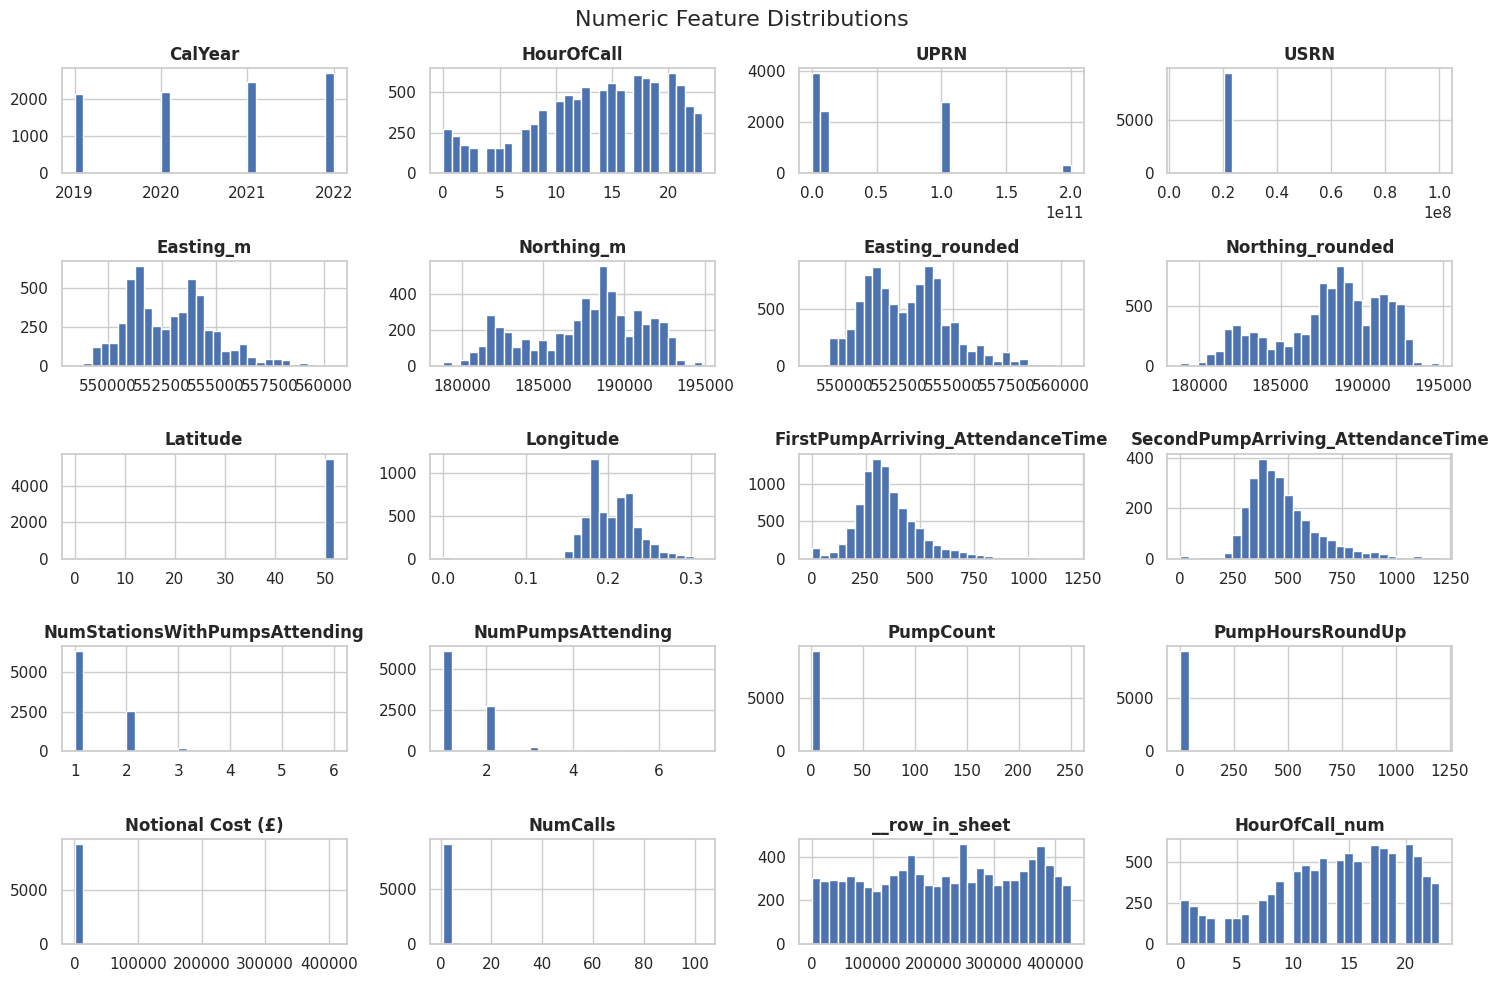

In [27]:
# EDA before clustering

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt


print(f"Shape: {hav.shape}")


missing_summary = hav.isna().sum().sort_values(ascending=False)
print("\nMissing values:\n", missing_summary[missing_summary > 0])

# Numeric-only correlation heatmap
num_df = hav.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# Outlier check: boxplots
plt.figure(figsize=(15,8))
num_df.boxplot(rot=90)
plt.title("Boxplots for Outlier Detection")
plt.show()

# Histograms for distribution check
num_df.hist(figsize=(15,10), bins=30)
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.show()


data_trimmed.dtypes

IncidentNumber                                     object
DateOfCall                                 datetime64[ns]
CalYear                                             int64
TimeOfCall                                         object
HourOfCall                                          int64
IncidentGroup                                      object
StopCodeDescription                                object
SpecialServiceType                                 object
PropertyCategory                                   object
PropertyType                                       object
AddressQualifier                                   object
Postcode_full                                      object
Postcode_district                                  object
UPRN                                                int64
USRN                                                int64
IncGeo_BoroughCode                                 object
IncGeo_BoroughName                                 

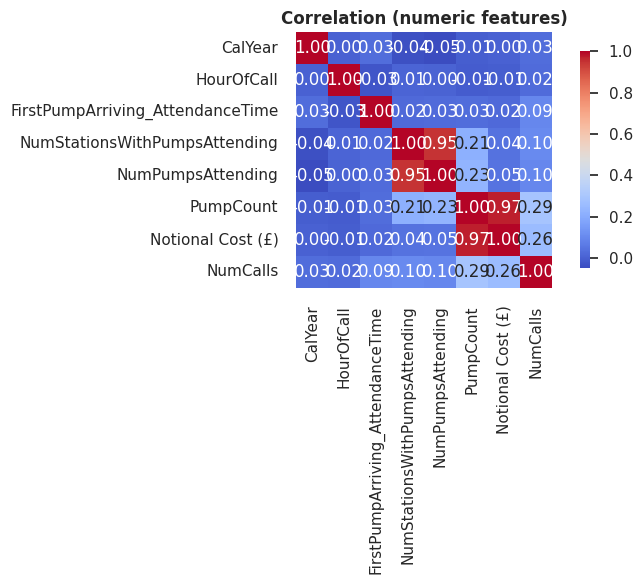


Correlations with Notional Cost (£):
Notional Cost (£)                   1.000000
PumpCount                           0.972342
NumCalls                            0.256459
NumPumpsAttending                   0.046051
NumStationsWithPumpsAttending       0.043556
FirstPumpArriving_AttendanceTime    0.023203
CalYear                             0.001572
HourOfCall                         -0.006132
Name: Notional Cost (£), dtype: float64

Scaled head():


,CalYear,HourOfCall,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,Notional Cost (£),NumCalls
0,-1.430146,-2.226184,-0.483574,-0.585830,-0.602671,-0.170742,-0.059865,-0.220594
1,-1.430146,-2.063905,0.282415,-0.585830,-0.602671,-0.170742,-0.059865,-0.220594
2,-1.430146,-1.901625,0.362344,-0.585830,-0.602671,-0.170742,-0.059865,0.250933
3,-1.430146,-0.116553,-0.703380,1.080802,0.912813,0.129811,-0.059865,-0.220594
4,-1.430146,1.343961,0.855241,-0.585830,-0.602671,-0.170742,-0.059865,-0.220594


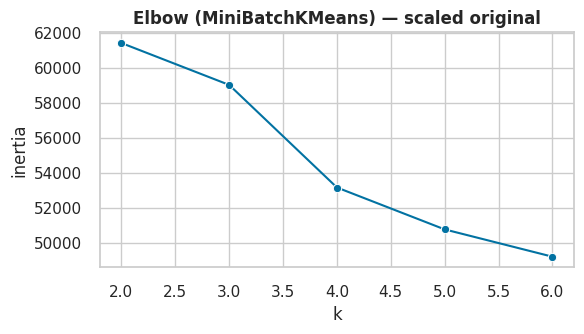

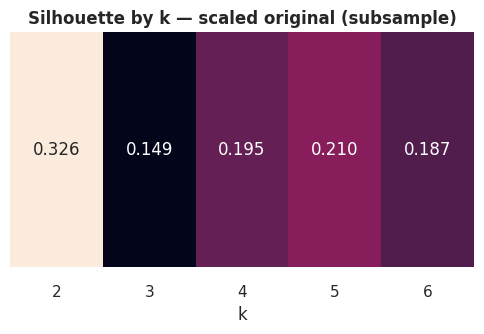

Best k (original scaled, subsample): k=2  sil=0.326
PCA(3) variance ratio: [0.294 0.217 0.132] | cumulative: 0.642


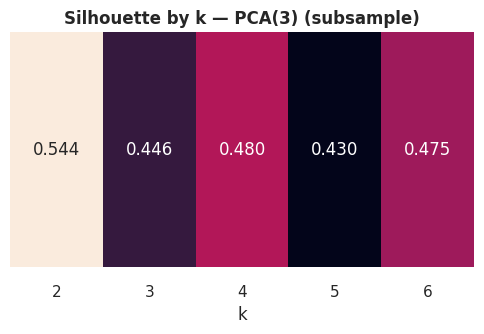

Best k (PCA3, subsample): k=2  sil=0.544
[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.006s...
[t-SNE] Computed neighbors for 3000 samples in 0.353s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.344581
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.989799
[t-SNE] KL divergence after 750 iterations: 0.540706
KMeans on t-SNE(3D, subsample) — silhouette (in t-SNE space): 0.332
Silhouette evaluated in original scaled space (same subsample): 0.155


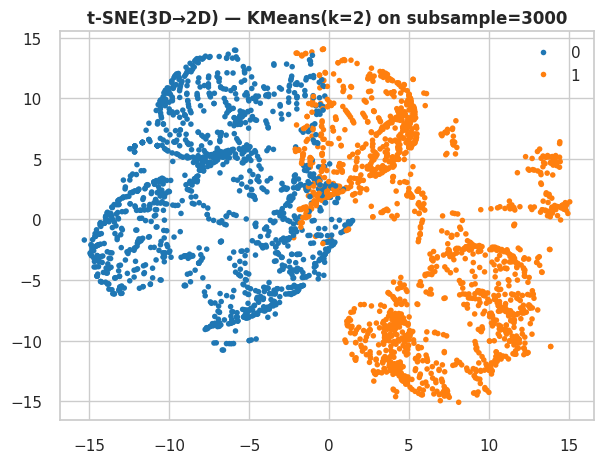

DBSCAN (t-SNE subsample): clusters=4, noise=29 (~1.0%), silhouette(core)=0.110


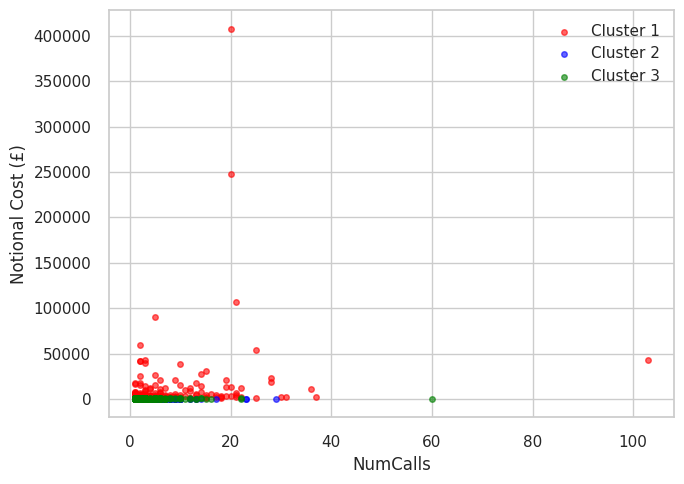


Cluster means (cost clustering):


,PumpCount,NumCalls,Notional Cost (£)
Cluster,,,
0,6.189840,4.711230,6670.732620
1,1.304491,1.273788,349.367927
2,1.856907,1.729529,785.741108


In [29]:
# Descriptive Model - Clustering Analysis

import warnings, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans as KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")
sns.set_context("notebook"); sns.set_style("whitegrid")
RNG = 42
rs  = np.random.RandomState(RNG)

KS                = [2,3,4,5,6]      # was 2..10
SIL_SAMPLE_N      = 3500             # subsample for silhouette calc
TSNE_SAMPLE_N     = 3000             # subsample for t-SNE
TSNE_ITERS        = 750              # was 5000
TSNE_PERPLEXITY   = 35               # safe for ~3k points
USE_TSNE          = True

data_trimmed = hav.copy()
if data_trimmed["DateOfCall"].dtype == "object":
    data_trimmed["DateOfCall"] = pd.to_datetime(data_trimmed["DateOfCall"], errors="coerce")

print("data_trimmed.dtypes\n")
print(data_trimmed.dtypes)

# 1) Standardize the data

num_cols = [
    'CalYear', 'HourOfCall', 'FirstPumpArriving_AttendanceTime',
    'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
    'Notional Cost (£)', 'NumCalls'
]
df_num = data_trimmed[num_cols].copy()

def check_null_values(df):
    na = df.isna().sum()
    print("\ncheck_null_values(df_num)\n")
    print(na)
    return na

_ = check_null_values(df_num)


# 2) Correlation Analysis on Numerical Columns

corr = df_num.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar_kws={"shrink": .85})
plt.title("Correlation (numeric features)")
plt.tight_layout(); plt.show()

corr_res = corr['Notional Cost (£)'].sort_values(ascending=False)
print("\nCorrelations with Notional Cost (£):")
print(corr_res)


# 3) Feature Scaling

df_filled = df_num.fillna(df_num.median(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filled)
df_scale = pd.DataFrame(X_scaled, columns=df_num.columns)
print("\nScaled head():")
display(df_scale.head())


def subsample(X, n, rng):
    if len(X) <= n:
        return X, np.arange(len(X))
    idx = rng.choice(len(X), size=n, replace=False)
    return X[idx], idx


# 4) Elbow (MiniBatchKMeans) on full scaled data

inertias = []
for k in KS:
    km = KMeans(n_clusters=k, random_state=RNG, batch_size=1024, n_init=10, max_iter=100)
    km.fit(df_scale.values)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,3.5))
sns.lineplot(x=KS, y=inertias, marker="o")
plt.title("Elbow (MiniBatchKMeans) — scaled original")
plt.xlabel("k"); plt.ylabel("inertia")
plt.tight_layout(); plt.show()

# 5) Silhouette (on subsample for speed)

X_sil, sil_idx = subsample(df_scale.values, SIL_SAMPLE_N, rs)
rows = []
for k in KS:
    km = KMeans(n_clusters=k, random_state=RNG, batch_size=1024, n_init=10, max_iter=100)
    lab = km.fit_predict(X_sil)
    sil = silhouette_score(X_sil, lab)
    rows.append((k, sil))
sil_orig = pd.DataFrame(rows, columns=["k","sil"]).set_index("k")

plt.figure(figsize=(5,3.5))
sns.heatmap(sil_orig.T, annot=True, fmt=".3f", cmap="rocket", cbar=False)
plt.title("Silhouette by k — scaled original (subsample)")
plt.yticks([])
plt.tight_layout(); plt.show()

best_k_orig = sil_orig["sil"].idxmax()
print(f"Best k (original scaled, subsample): k={best_k_orig}  sil={sil_orig.loc[best_k_orig,'sil']:.3f}")

# 6) PCA (variance & 3D)

pca3 = PCA(n_components=3, random_state=RNG)
X_pca3 = pca3.fit_transform(df_scale.values)
print("PCA(3) variance ratio:", np.round(pca3.explained_variance_ratio_, 3),
      "| cumulative:", round(pca3.explained_variance_ratio_.sum(), 3))

# Elbow + silhouette on PCA(3)
Xp_sil, _ = subsample(X_pca3, SIL_SAMPLE_N, rs)
rows = []
for k in KS:
    km = KMeans(n_clusters=k, random_state=RNG, batch_size=1024, n_init=10, max_iter=100)
    lab = km.fit_predict(Xp_sil)
    sil = silhouette_score(Xp_sil, lab)
    rows.append((k, sil))
sil_pca = pd.DataFrame(rows, columns=["k","sil"]).set_index("k")

plt.figure(figsize=(5,3.5))
sns.heatmap(sil_pca.T, annot=True, fmt=".3f", cmap="rocket", cbar=False)
plt.title("Silhouette by k — PCA(3) (subsample)")
plt.yticks([]); plt.tight_layout(); plt.show()

best_k_pca = sil_pca["sil"].idxmax()
print(f"Best k (PCA3, subsample): k={best_k_pca}  sil={sil_pca.loc[best_k_pca,'sil']:.3f}")


# 7) t-SNE (3D) — subsample

if USE_TSNE:
    X_tsne_in, tsne_idx = subsample(df_scale.values, TSNE_SAMPLE_N, rs)
    tsne = TSNE(n_components=3, perplexity=TSNE_PERPLEXITY,
                learning_rate="auto", n_iter=TSNE_ITERS,
                init="pca", random_state=RNG, verbose=1)
    X_tsne3 = tsne.fit_transform(X_tsne_in)

    # Choose k from PCA best
    km_tsne = KMeans(n_clusters=int(best_k_pca), random_state=RNG, batch_size=1024, n_init=10, max_iter=100)
    lab_tsne = km_tsne.fit_predict(X_tsne3)


    sil_tsne_in_orig = silhouette_score(X_tsne_in, lab_tsne)
    print(f"KMeans on t-SNE(3D, subsample) — silhouette (in t-SNE space): "
          f"{silhouette_score(X_tsne3, lab_tsne):.3f}")
    print(f"Silhouette evaluated in original scaled space (same subsample): "
          f"{sil_tsne_in_orig:.3f}")


    plt.figure(figsize=(6.2,4.8))
    sns.scatterplot(x=X_tsne3[:,0], y=X_tsne3[:,1], hue=lab_tsne, palette="tab10", s=16, edgecolor="none")
    plt.title(f"t-SNE(3D→2D) — KMeans(k={int(best_k_pca)}) on subsample={len(X_tsne3)}")
    plt.tight_layout(); plt.show()

-
# 8) DBSCAN on t-SNE subsample

if USE_TSNE:
    db = DBSCAN(eps=2.5, min_samples=20).fit(X_tsne3)
    labels_db = db.labels_
    n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise_ = int((labels_db == -1).sum())
    # Silhouette on the *core* (non-noise)
    mask_core = labels_db != -1
    sil_db = silhouette_score(X_tsne3[mask_core], labels_db[mask_core]) if n_clusters_ > 1 and mask_core.any() else np.nan
    print(f"DBSCAN (t-SNE subsample): clusters={n_clusters_}, noise={n_noise_} (~{n_noise_/len(labels_db):.1%}), silhouette(core)={sil_db:.3f}")


# 9) Cost-only clustering

col = ['PumpCount', 'NumCalls', 'Notional Cost (£)']
df_cost = data_trimmed[col].copy()
df_cost = df_cost.fillna(df_cost.median(numeric_only=True))

km_cost = KMeans(n_clusters=3, random_state=RNG, batch_size=1024, n_init=10, max_iter=100)
df_cost["Cluster"] = km_cost.fit_predict(df_cost.values)

plt.figure(figsize=(7,5))
colors = ['red', 'blue', 'green']
for i, c in enumerate(colors):
    sel = df_cost["Cluster"] == i
    plt.scatter(df_cost.loc[sel, "NumCalls"], df_cost.loc[sel, "Notional Cost (£)"],
                color=c, label=f'Cluster {i+1}', s=16, alpha=0.6)
plt.xlabel('NumCalls'); plt.ylabel('Notional Cost (£)'); plt.legend(); plt.tight_layout(); plt.show()

print("\nCluster means (cost clustering):")
display(df_cost.groupby('Cluster', as_index=True).mean(numeric_only=True))


Target classes: {'False Alarm': np.int64(3995), 'Fire': np.int64(2202), 'Special Service': np.int64(3268)}
Majority-class baseline accuracy: 0.422
Train: (7098, 13) | Test: (2367, 13)

=== KNN (tuned) ===
Best params: {'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'distance'}
CV best f1_weighted: 0.712
Test acc: 0.727 | Test f1_w: 0.723
                 precision    recall  f1-score   support

    False Alarm       0.71      0.77      0.74       999
           Fire       0.71      0.54      0.61       551
Special Service       0.75      0.80      0.78       817

       accuracy                           0.73      2367
      macro avg       0.72      0.70      0.71      2367
   weighted avg       0.73      0.73      0.72      2367



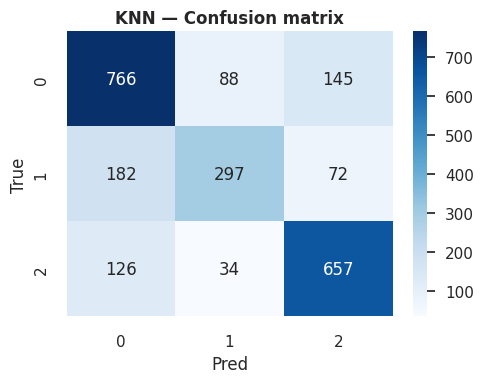


=== RandomForest (tuned) ===
Best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
CV best f1_weighted: 0.784
Test acc: 0.787 | Test f1_w: 0.787
                 precision    recall  f1-score   support

    False Alarm       0.86      0.72      0.79       999
           Fire       0.69      0.80      0.74       551
Special Service       0.79      0.85      0.82       817

       accuracy                           0.79      2367
      macro avg       0.78      0.79      0.78      2367
   weighted avg       0.80      0.79      0.79      2367



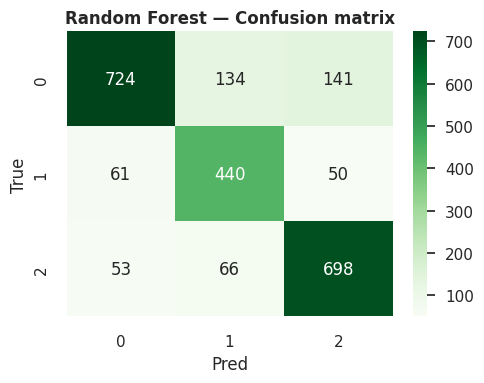


Top features — Random Forest:


,feature,importance
205,PropertyCategory_Non Residential,0.072259
6,Notional Cost (£),0.068019
204,PropertyCategory_Dwelling,0.065057
207,PropertyCategory_Outdoor,0.063021
7,NumCalls,0.057629
2,FirstPumpArriving_AttendanceTime,0.052336
5,PumpCount,0.050590
4,NumPumpsAttending,0.049063
210,PropertyCategory_Road Vehicle,0.041002
208,PropertyCategory_Outdoor Structure,0.039862


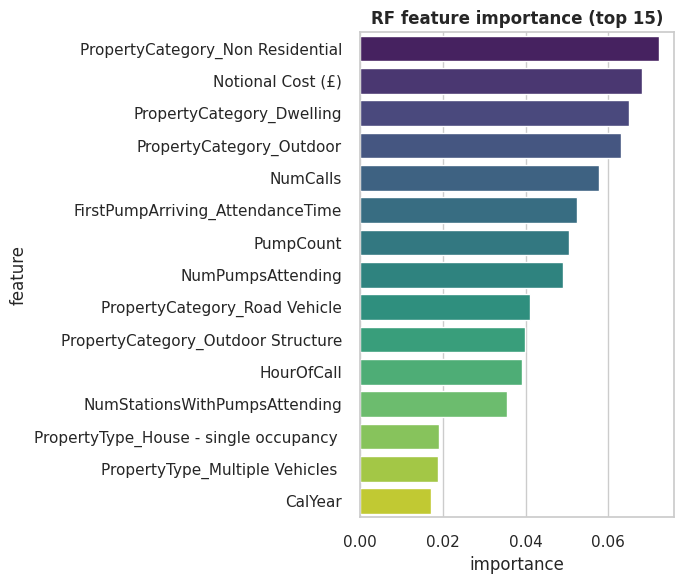

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [37]:

# Supervised models: KNN vs Random Forest vs XGBoost

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

sns.set_context("notebook"); sns.set_style("whitegrid")
RNG = 42
np.random.seed(RNG)


base = hav.copy()

# Target (multi-class): IncidentGroup

y = base["IncidentGroup"].astype(str)


num_cols = [
    "CalYear", "HourOfCall", "FirstPumpArriving_AttendanceTime",
    "NumStationsWithPumpsAttending", "NumPumpsAttending",
    "PumpCount", "Notional Cost (£)", "NumCalls"
]

# Categorical features
cat_cols = [
    "PropertyType", "PropertyCategory", "Postcode_district",
    "IncGeo_WardNameNew", "IncidentStationGround"
]


use_cols = num_cols + cat_cols + ["IncidentGroup"]
df = base[use_cols].copy()


class_counts = y.value_counts().sort_index()
print("Target classes:", dict(class_counts))

baseline = y.value_counts(normalize=True).max()
print(f"Majority-class baseline accuracy: {baseline:.3f}")



# 1) Train / Test split

X = df.drop(columns=["IncidentGroup"])
y = df["IncidentGroup"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RNG, stratify=y
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")


# 2) Preprocessing

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], remainder="drop")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

# 3) KNN (fast grid)

knn_pipe = Pipeline([
    ("prep", pre),
    ("clf", KNeighborsClassifier())
])
knn_grid = {
    "clf__n_neighbors": [3, 5, 7, 11],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],   # Manhattan / Euclidean
}
knn_gs = GridSearchCV(
    knn_pipe, knn_grid, cv=cv, scoring="f1_weighted",
    n_jobs=-1, verbose=0, refit=True
)
knn_gs.fit(X_train, y_train)
y_pred_knn = knn_gs.predict(X_test)

print("\n=== KNN (tuned) ===")
print("Best params:", knn_gs.best_params_)
print(f"CV best f1_weighted: {knn_gs.best_score_:.3f}")
print(f"Test acc: {accuracy_score(y_test, y_pred_knn):.3f} | Test f1_w: {f1_score(y_test, y_pred_knn, average='weighted'):.3f}")
print(classification_report(y_test, y_pred_knn))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Blues")
plt.title("KNN — Confusion matrix"); plt.xlabel("Pred"); plt.ylabel("True")
plt.tight_layout(); plt.show()


# 4) Random Forest

rf_pipe = Pipeline([
    ("prep", pre),
    ("clf", RandomForestClassifier(
        random_state=RNG, n_jobs=-1, class_weight="balanced"
    ))
])
rf_grid = {
    "clf__n_estimators": [300, 500],
    "clf__max_depth": [None, 12],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt"]
}
rf_gs = GridSearchCV(
    rf_pipe, rf_grid, cv=cv, scoring="f1_weighted",
    n_jobs=-1, verbose=0, refit=True
)
rf_gs.fit(X_train, y_train)
y_pred_rf = rf_gs.predict(X_test)

print("\n=== RandomForest (tuned) ===")
print("Best params:", rf_gs.best_params_)
print(f"CV best f1_weighted: {rf_gs.best_score_:.3f}")
print(f"Test acc: {accuracy_score(y_test, y_pred_rf):.3f} | Test f1_w: {f1_score(y_test, y_pred_rf, average='weighted'):.3f}")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest — Confusion matrix"); plt.xlabel("Pred"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Feature importance for RF (top 15)
pre_fitted = rf_gs.best_estimator_.named_steps["prep"]
rf_best = rf_gs.best_estimator_.named_steps["clf"]


num_names = num_cols
cat_ohe_names = list(pre_fitted.named_transformers_["cat"]
                     .named_steps["onehot"]
                     .get_feature_names_out(cat_cols))
feat_names = num_names + cat_ohe_names

imp_rf = pd.DataFrame({
    "feature": feat_names,
    "importance": rf_best.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop features — Random Forest:")
display(imp_rf.head(15))

plt.figure(figsize=(7,6))
sns.barplot(data=imp_rf.head(15), x="importance", y="feature", palette="viridis")
plt.title("RF feature importance (top 15)")
plt.tight_layout(); plt.show()


# 5) XGBoost (fast manual search + early stopping)

if HAS_XGB:

    Xtr_enc = pre.fit_transform(X_train, y_train)
    Xte_enc = pre.transform(X_test)

    X_tr, X_val, y_tr, y_val = train_test_split(
        Xtr_enc, y_train, test_size=0.2, random_state=RNG, stratify=y_train
    )

    # Class weights for imbalance
    freq = y_tr.value_counts()
    w_map = (1.0 / freq).to_dict()
    sample_weight = y_tr.map(w_map).values


    param_grid = [
        dict(n_estimators=400, max_depth=6, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9),
        dict(n_estimators=600, max_depth=8, learning_rate=0.08, subsample=0.9, colsample_bytree=0.9),
        dict(n_estimators=300, max_depth=6, learning_rate=0.15, subsample=1.0, colsample_bytree=1.0),
    ]

    best = {"f1": -1, "model": None, "params": None}
    for p in param_grid:
        xgb = XGBClassifier(
            objective="multi:softprob",
            num_class=y_train.nunique(),
            eval_metric="mlogloss",
            random_state=RNG,
            n_jobs=-1,
            **p
        )
        xgb.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30,
            sample_weight=sample_weight,
            verbose=False
        )

        from sklearn.metrics import f1_score
        y_val_pred = xgb.predict(X_val)
        f1w = f1_score(y_val, y_val_pred, average="weighted")
        if f1w > best["f1"]:
            best.update({"f1": f1w, "model": xgb, "params": p})

    xgb_best = best["model"]
    y_pred_xgb = xgb_best.predict(Xte_enc)

    print("\n=== XGBoost (fast tuned) ===")
    print("Best params:", best["params"])
    print(f"Val f1_weighted (early-stopping selection): {best['f1']:.3f}")
    print(f"Test acc: {accuracy_score(y_test, y_pred_xgb):.3f} | Test f1_w: {f1_score(y_test, y_pred_xgb, average='weighted'):.3f}")
    print(classification_report(y_test, y_pred_xgb))

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Oranges")
    plt.title("XGBoost — Confusion matrix"); plt.xlabel("Pred"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    imp_xgb = pd.DataFrame({
        "feature": feat_names,
        "importance": xgb_best.feature_importances_
    }).sort_values("importance", ascending=False)

    print("\nTop features — XGBoost:")
    display(imp_xgb.head(15))

    plt.figure(figsize=(7,6))
    sns.barplot(data=imp_xgb.head(15), x="importance", y="feature", palette="magma")
    plt.title("XGBoost feature importance (top 15)")
    plt.tight_layout(); plt.show()

# 6) Comparison
rows = [
    ("KNN (tuned)",  knn_gs.best_score_,  accuracy_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn, average="weighted")),
    ("RandomForest (tuned)", rf_gs.best_score_, accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf, average="weighted")),
]
if HAS_XGB:
    rows.append(("XGBoost (fast tuned)", np.nan, accuracy_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_xgb, average="weighted")))

summary = pd.DataFrame(rows, columns=["model", "cv_f1_weighted", "test_accuracy", "test_f1_weighted"])
print("\n=== Model comparison ===")
display(summary)
